In [3]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models


import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

## **Preparing Dataset**

In [4]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 20141, done.
remote: Counting objects: 100% (1961/1961), done.
remote: Compressing objects: 100% (1055/1055), done.
remote: Total 20141 (delta 909), reused 1584 (delta 595), pack-reused 18180
Receiving objects: 100% (20141/20141), 33.15 MiB | 27.55 MiB/s, done.
Resolving deltas: 100% (11003/11003), done.


In [5]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [6]:
# Download data and extract it to folder
get_data_extract()

4996292608/4996278331 [==============================] - 197s 0us/step
Dataset downloaded and extracted!


In [7]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [8]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [9]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [10]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [11]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [12]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [13]:
# picking 3 food items and generating separate data folders for the same
food_list = ['deviled_eggs','beef_tartare','hot_dog','lobster_bisque','sushi','tuna_tartare','fried_rice','samosa','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [14]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into deviled_eggs
Copying images into beef_tartare
Copying images into hot_dog
Copying images into lobster_bisque
Copying images into sushi
Copying images into tuna_tartare
Copying images into fried_rice
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [15]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
7500


In [16]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into deviled_eggs
Copying images into beef_tartare
Copying images into hot_dog
Copying images into lobster_bisque
Copying images into sushi
Copying images into tuna_tartare
Copying images into fried_rice
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [17]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
2500


## **Training**

In [18]:
def generate_model(n_pairs,n_filters,kernel_size):
  model = tf.keras.Sequential(
  [
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(n_filters, (kernel_size,kernel_size), padding='same', activation="relu",input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  ]
  )
  for i in range(n_pairs-1):
    model.add(tf.keras.layers.Conv2D(n_filters, (kernel_size,kernel_size), padding='same', activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(10, activation="softmax"))
  input_shape = (None, 128, 128, 3)
  model.build(input_shape)
  
  return model


def train_model_v2(model,n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 128, 128
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=None,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=None)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
  
    
  
  
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  from tensorflow.keras.callbacks import EarlyStopping
  callbacks = [
              EarlyStopping(patience=2)
  ]

  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor='loss',
      mode='min',
      save_best_only=True)

  callbacks = [
              EarlyStopping(patience=4),
              model_checkpoint_callback,
  ]


  history = model.fit(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks)

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map, model

  

In [2]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

# **3 pairs 32 filter kernel_size 3**

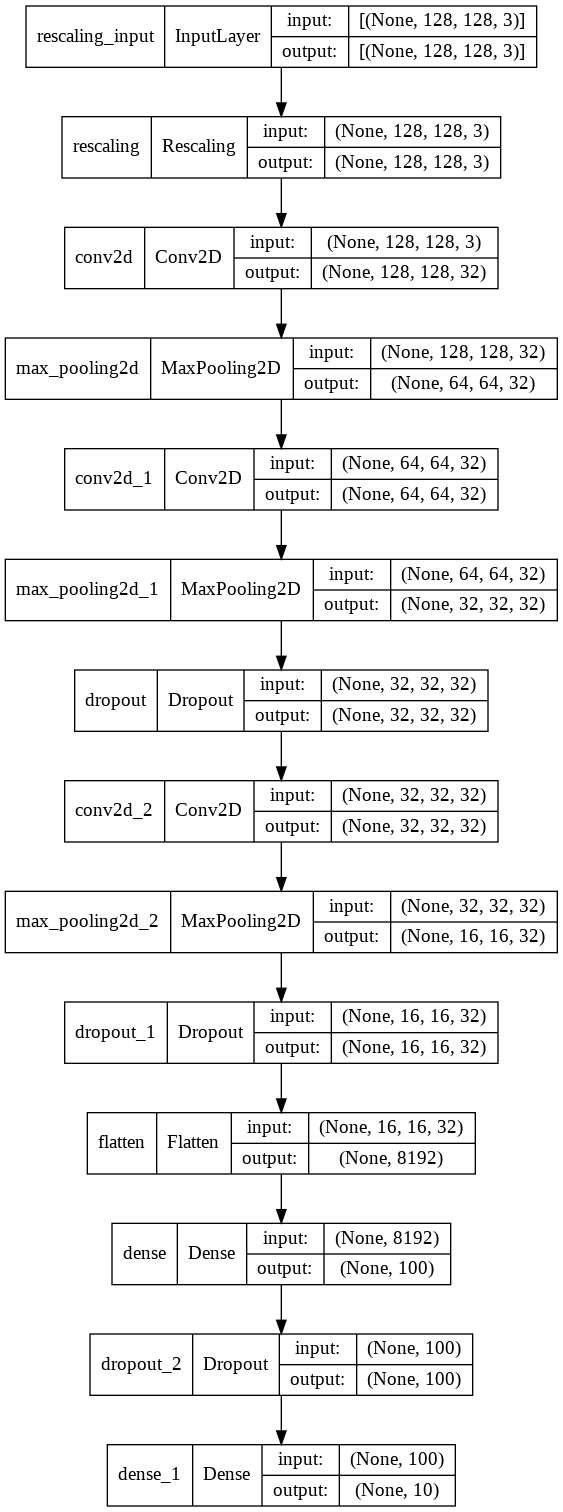

In [19]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 3
n_filters = 32
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True

In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 83s 158ms/step - loss: 2.2745 - accuracy: 0.1383 - val_loss: 2.2292 - val_accuracy: 0.1795
Epoch 2/50
468/468 [==============================] - 71s 151ms/step - loss: 2.2023 - accuracy: 0.1887 - val_loss: 2.1236 - val_accuracy: 0.2324
Epoch 3/50
468/468 [==============================] - 74s 158ms/step - loss: 2.1196 - accuracy: 0.2258 - val_loss: 1.9548 - val_accuracy: 0.3077
Epoch 4/50
468/468 [==============================] - 74s 157ms/step - loss: 1.9786 - accuracy: 0.2843 - val_loss: 1.8000 - val_accuracy: 0.3638
Epoch 5/50
468/468 [==============================] - 74s 158ms/step - loss: 1.8299 - accuracy: 0.3417 - val_loss: 1.6712 - val_accuracy: 0.4267
Epoch 6/50
468/468 [==============================] - 73s 156ms/step - loss: 1.7426 - accuracy: 0.3915 - val_loss: 1.6181 - val_accuracy: 0.4339
Epoch 7/50
468/468 [========================

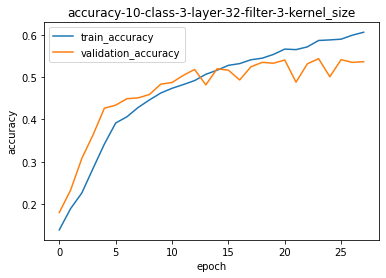

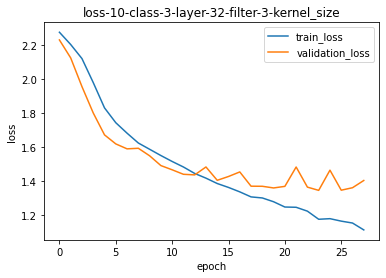

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-3-layer-32-filter-3-kernel_size')
plt.savefig('accuracy-10-class-5-layer-32-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-3-layer-32-filter-3-kernel_size')
plt.savefig('loss-10-class-5-layer-32-filter-3-kernel_size.jpg')

## **4 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 4
n_filters = 32
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True

In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 80s 168ms/step - loss: 2.2745 - accuracy: 0.1375 - val_loss: 2.2043 - val_accuracy: 0.1847
Epoch 2/50
468/468 [==============================] - 80s 172ms/step - loss: 2.1523 - accuracy: 0.2154 - val_loss: 2.0174 - val_accuracy: 0.2704
Epoch 3/50
468/468 [==============================] - 89s 191ms/step - loss: 2.0175 - accuracy: 0.2875 - val_loss: 1.8220 - val_accuracy: 0.3602
Epoch 4/50
468/468 [==============================] - 80s 171ms/step - loss: 1.8777 - accuracy: 0.3363 - val_loss: 1.7411 - val_accuracy: 0.3910
Epoch 5/50
468/468 [==============================] - 80s 170ms/step - loss: 1.7694 - accuracy: 0.3824 - val_loss: 1.5955 - val_accuracy: 0.4391
Epoch 6/50
468/468 [==============================] - 76s 163ms/step - loss: 1.7020 - accuracy: 0.4007 - val_loss: 1.6054 - val_accuracy: 0.4355
Epoch 7/50
468/468 [========================

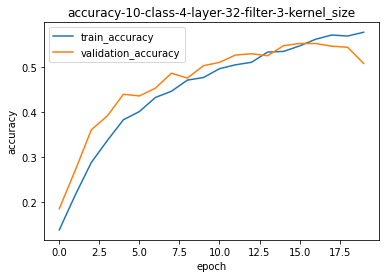

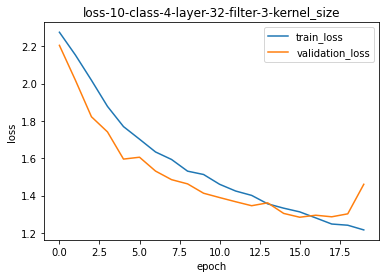

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-4-layer-32-filter-3-kernel_size')
plt.savefig('accuracy-10-class-4-layer-32-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-4-layer-32-filter-3-kernel_size')
plt.savefig('loss-10-class-4-layer-32-filter-3-kernel_size.jpg')

## **5 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 32
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
#keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True

In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 88s 185ms/step - loss: 2.2641 - accuracy: 0.1426 - val_loss: 2.2379 - val_accuracy: 0.1627
Epoch 2/50
468/468 [==============================] - 77s 164ms/step - loss: 2.1230 - accuracy: 0.2203 - val_loss: 2.0190 - val_accuracy: 0.2744
Epoch 3/50
468/468 [==============================] - 86s 185ms/step - loss: 2.0463 - accuracy: 0.2509 - val_loss: 1.9430 - val_accuracy: 0.2865
Epoch 4/50
468/468 [==============================] - 86s 183ms/step - loss: 1.9704 - accuracy: 0.2897 - val_loss: 1.8410 - val_accuracy: 0.3297
Epoch 5/50
468/468 [==============================] - 77s 165ms/step - loss: 1.8948 - accuracy: 0.3216 - val_loss: 1.7754 - val_accuracy: 0.3626
Epoch 6/50
468/468 [==============================] - 74s 159ms/step - loss: 1.8306 - accuracy: 0.3540 - val_loss: 1.6944 - val_accuracy: 0.4038
Epoch 7/50
468/468 [========================

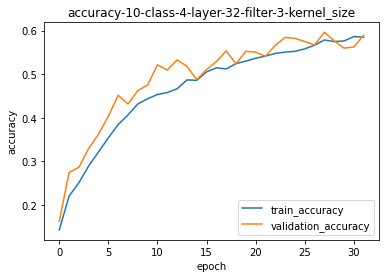

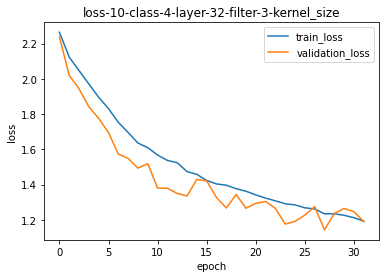

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-4-layer-32-filter-3-kernel_size')
plt.savefig('Accuracy-10-class-5-layer-32-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-4-layer-32-filter-3-kernel_size')
plt.savefig('Loss-10-class-5-layer-32-filter-3-kernel_size.jpg')

## **6 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 6
n_filters = 32
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
#keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True

In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 100s 188ms/step - loss: 2.3036 - accuracy: 0.0993 - val_loss: 2.3028 - val_accuracy: 0.1002
Epoch 2/50
468/468 [==============================] - 77s 164ms/step - loss: 2.3028 - accuracy: 0.0994 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 3/50
468/468 [==============================] - 74s 159ms/step - loss: 2.3036 - accuracy: 0.0961 - val_loss: 2.3027 - val_accuracy: 0.0998
Epoch 4/50
468/468 [==============================] - 74s 159ms/step - loss: 2.3032 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/50
468/468 [==============================] - 74s 159ms/step - loss: 2.3031 - accuracy: 0.0947 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 6/50
468/468 [==============================] - 74s 159ms/step - loss: 2.3029 - accuracy: 0.0947 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/50
468/468 [=======================

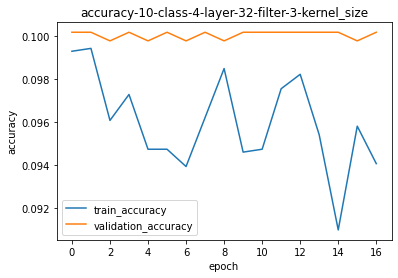

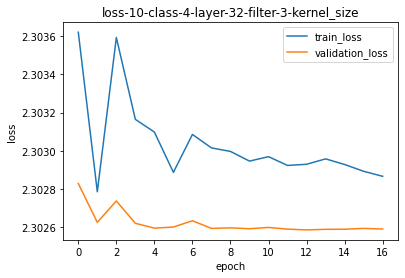

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-4-layer-32-filter-3-kernel_size')
plt.savefig('Accuracy-10-class-6-layer-32-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-4-layer-32-filter-3-kernel_size')
plt.savefig('Loss-10-class-6-layer-32-filter-3-kernel_size.jpg')

## **5 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 32
kernel_size = 3
history, class_map_10, model = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/20
468/468 [==============================] - 83s 173ms/step - loss: 2.2914 - accuracy: 0.1132 - val_loss: 2.2019 - val_accuracy: 0.1751
Epoch 2/20
468/468 [==============================] - 82s 174ms/step - loss: 2.1849 - accuracy: 0.1807 - val_loss: 2.1196 - val_accuracy: 0.2368
Epoch 3/20
468/468 [==============================] - 81s 174ms/step - loss: 2.0986 - accuracy: 0.2326 - val_loss: 1.9961 - val_accuracy: 0.3029
Epoch 4/20
468/468 [==============================] - 91s 194ms/step - loss: 2.0238 - accuracy: 0.2664 - val_loss: 1.8923 - val_accuracy: 0.3462
Epoch 5/20
468/468 [==============================] - 91s 194ms/step - loss: 1.9501 - accuracy: 0.3065 - val_loss: 1.8048 - val_accuracy: 0.3838
Epoch 6/20
468/468 [==============================] - 90s 192ms/step - loss: 1.8809 - accuracy: 0.3302 - val_loss: 1.7919 - val_accuracy: 0.3458
Epoch 7/20
468/468 [========================

In [ ]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)#show_shapes=True,show_layer_names=True,expand_nested=True

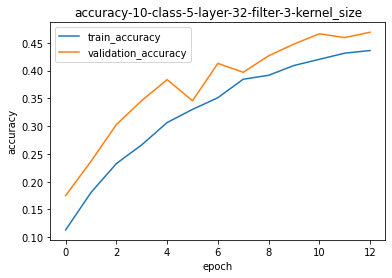

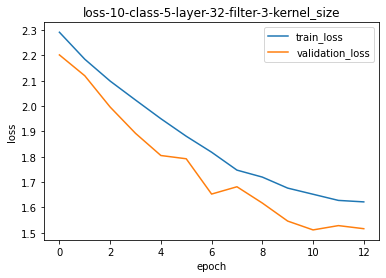

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-32-filter-3-kernel_size')
plt.savefig('accuracy-10-class-5-layer-32-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-32-filter-3-kernel_size')
plt.savefig('loss-10-class-5-layer-32-filter-3-kernel_size.jpg')

## generate Model 

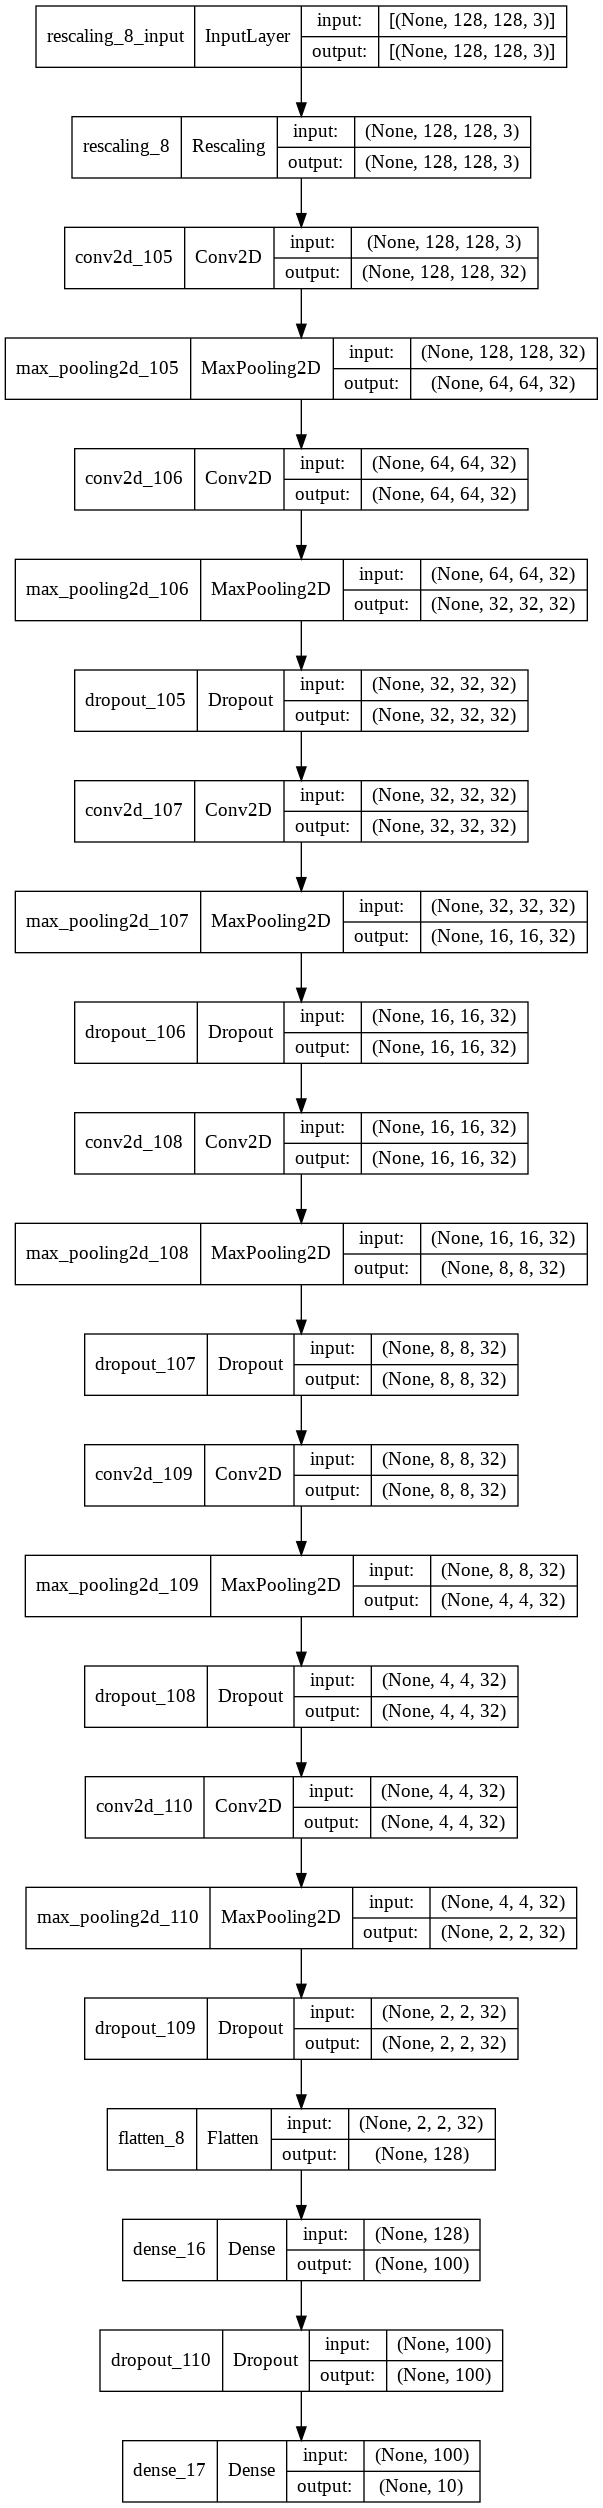

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 6
n_filters = 32
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True

In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/20
468/468 [==============================] - 99s 209ms/step - loss: 2.3036 - accuracy: 0.0930 - val_loss: 2.3001 - val_accuracy: 0.1022
Epoch 2/20
468/468 [==============================] - 79s 169ms/step - loss: 2.2432 - accuracy: 0.1603 - val_loss: 2.1278 - val_accuracy: 0.2200
Epoch 3/20
468/468 [==============================] - 88s 189ms/step - loss: 2.1262 - accuracy: 0.2202 - val_loss: 1.9939 - val_accuracy: 0.2808
Epoch 4/20
468/468 [==============================] - 88s 188ms/step - loss: 2.0337 - accuracy: 0.2664 - val_loss: 1.9286 - val_accuracy: 0.2969
Epoch 5/20
468/468 [==============================] - 80s 170ms/step - loss: 1.9451 - accuracy: 0.3026 - val_loss: 1.8084 - val_accuracy: 0.3562
Epoch 6/20
468/468 [==============================] - 89s 190ms/step - loss: 1.8900 - accuracy: 0.3239 - val_loss: 1.7770 - val_accuracy: 0.3762
Epoch 7/20
468/468 [========================

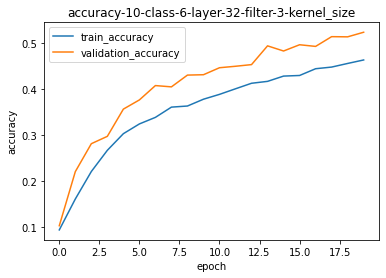

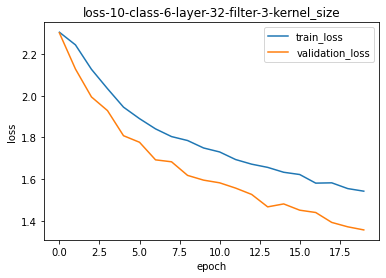

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-6-layer-32-filter-3-kernel_size')
plt.savefig('accuracy-10-class-6-layer-32-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-6-layer-32-filter-3-kernel_size')
plt.savefig('loss-10-class-6-layer-32-filter-3-kernel_size.jpg')

# 7

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 7
n_filters = 32
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True

In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 81s 171ms/step - loss: 2.3035 - accuracy: 0.0959 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 2/50
468/468 [==============================] - 89s 191ms/step - loss: 2.3033 - accuracy: 0.0935 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 3/50
468/468 [==============================] - 89s 189ms/step - loss: 2.3032 - accuracy: 0.1009 - val_loss: 2.3027 - val_accuracy: 0.1002
Epoch 4/50
468/468 [==============================] - 79s 169ms/step - loss: 2.3030 - accuracy: 0.1005 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/50
468/468 [==============================] - 84s 180ms/step - loss: 2.3031 - accuracy: 0.0913 - val_loss: 2.3026 - val_accuracy: 0.1002
{'beef_tartare': 0, 'deviled_eggs': 1, 'fried_rice': 2, 'hot_dog': 3, 'lobster_bisque': 4, 'omelette': 5, 'pizza': 6, 'samosa': 7, 'sushi': 8, 'tuna_tartare': 9}


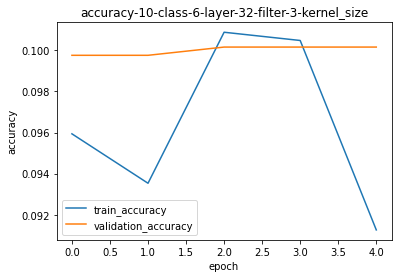

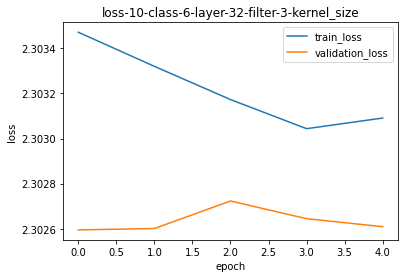

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-6-layer-32-filter-3-kernel_size')
plt.savefig('accuracy-10-class-6-layer-32-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-6-layer-32-filter-3-kernel_size')
plt.savefig('loss-10-class-6-layer-32-filter-3-kernel_size.jpg')

## **6 pair 50 iteration**

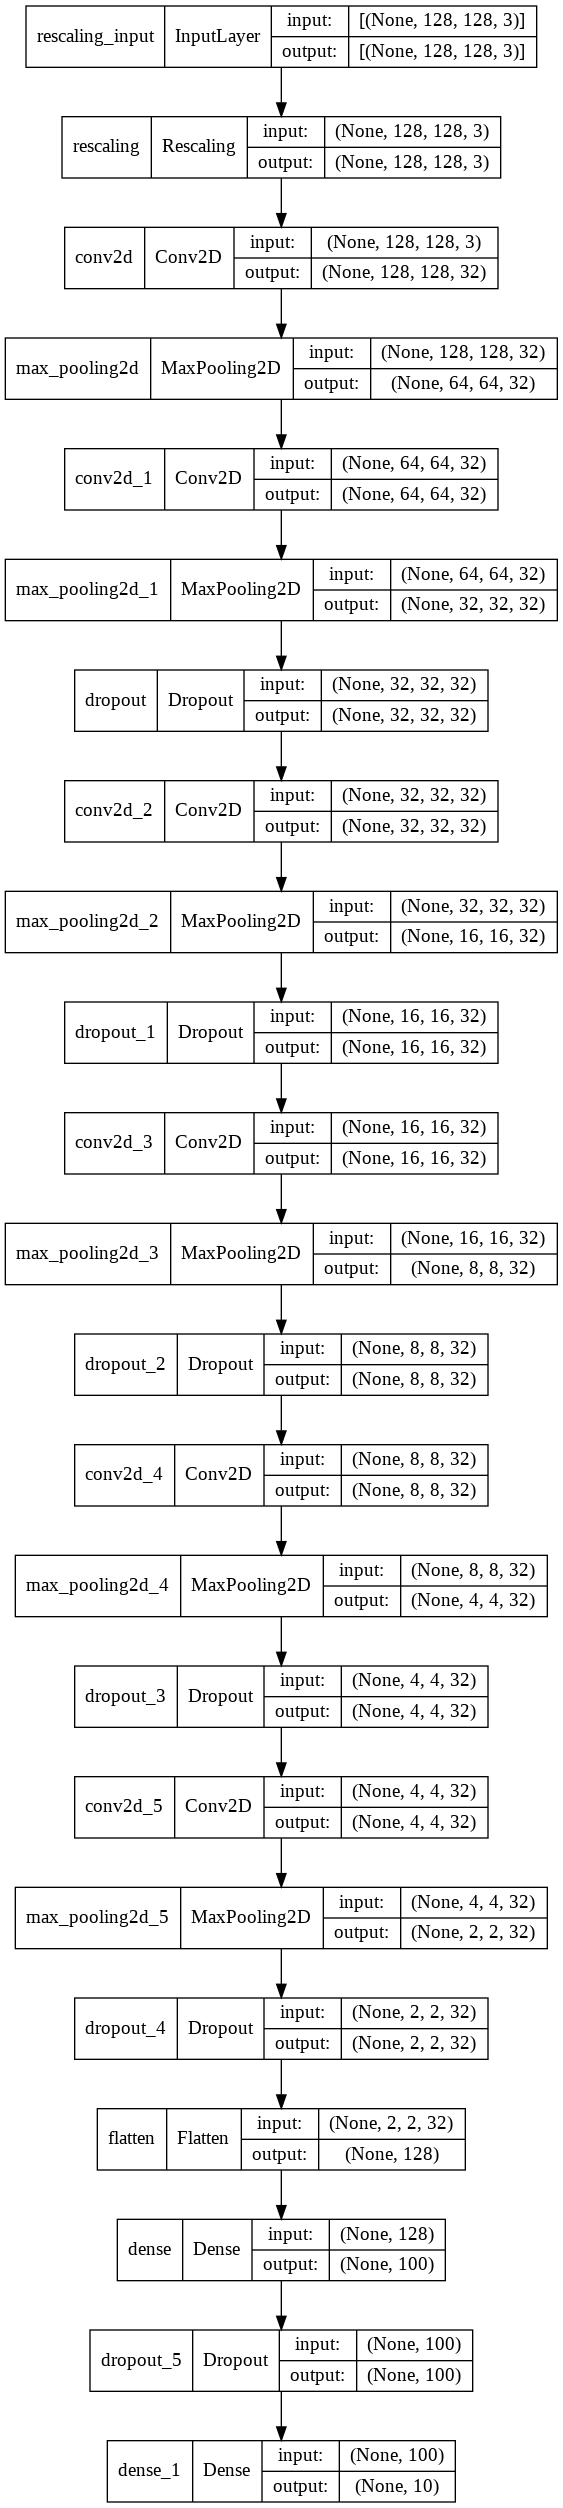

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 6
n_filters = 32
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True

In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 91s 192ms/step - loss: 2.3040 - accuracy: 0.1011 - val_loss: 2.3028 - val_accuracy: 0.1002
Epoch 2/50
468/468 [==============================] - 80s 171ms/step - loss: 2.3031 - accuracy: 0.0959 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 3/50
468/468 [==============================] - 86s 183ms/step - loss: 2.3032 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.0994
Epoch 4/50
468/468 [==============================] - 77s 165ms/step - loss: 2.3032 - accuracy: 0.0883 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 5/50
468/468 [==============================] - 81s 173ms/step - loss: 2.3030 - accuracy: 0.0950 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 6/50
468/468 [==============================] - 78s 166ms/step - loss: 2.3032 - accuracy: 0.0951 - val_loss: 2.3026 - val_accuracy: 0.0994
Epoch 7/50
468/468 [========================

In [ ]:
plot_accuracy(history,'accuracy-10-class-6-layer-32-filter-3-kernel_size-50-iteration')
plt.savefig('accuracy-10-class-6-layer-32-filter-3-kernel_size-50-iteration.jpg')

plot_loss(history,'loss-10-class-6-layer-32-filter-3-kernel_size-50-iteration')
plt.savefig('loss-10-class-6-layer-32-filter-3-kernel_size-50-teration.jpg')

# **As you can seen, the best architecture consists of 5 convlution pairs**

# **#Kernel**

# **5 pairs 8 filter kernel_size 3**

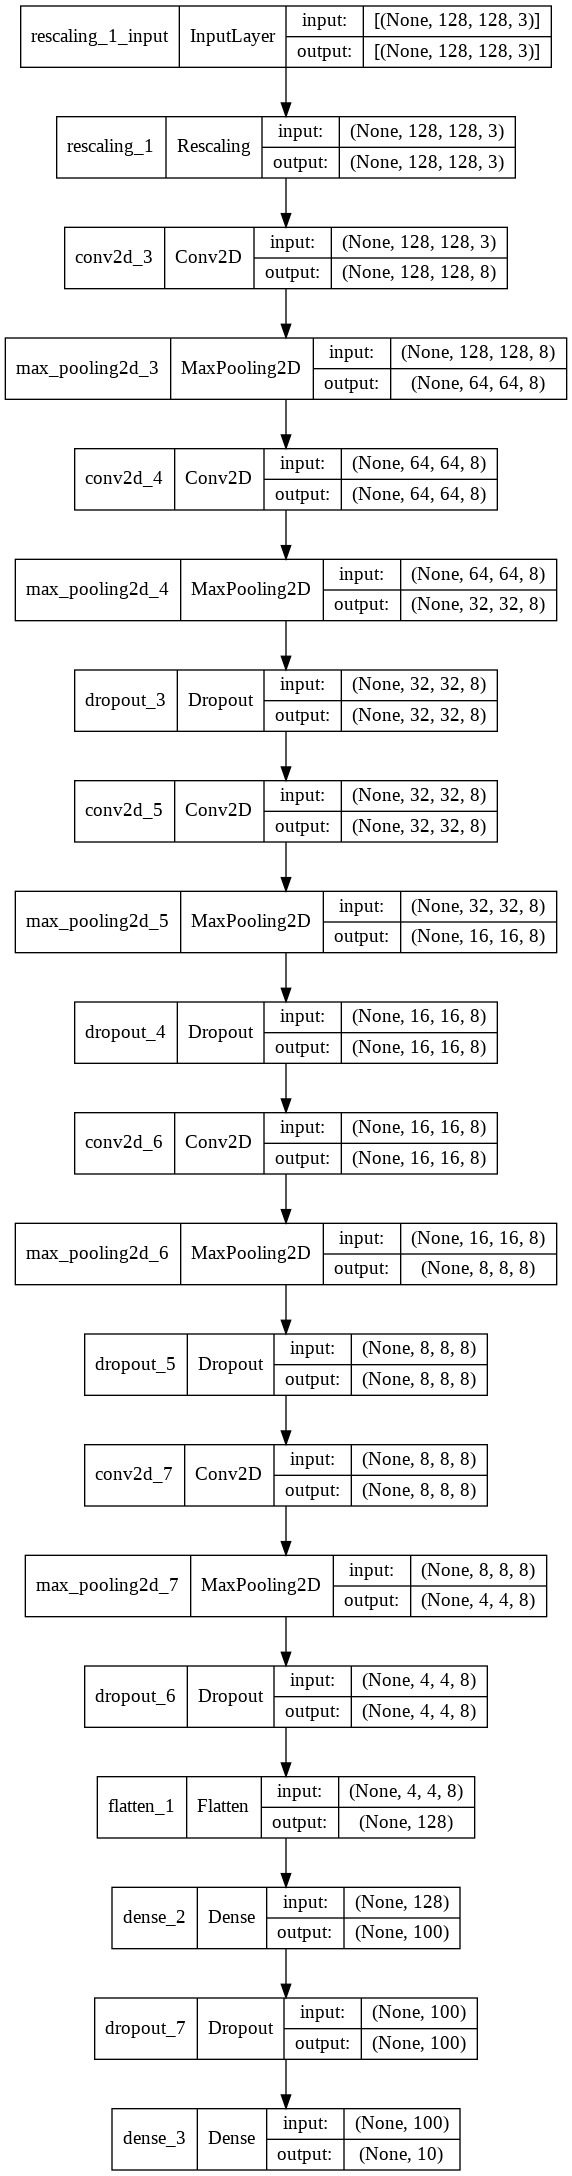

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 8
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True

In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 143s 303ms/step - loss: 2.2503 - accuracy: 0.1597 - val_loss: 2.1923 - val_accuracy: 0.1859
Epoch 2/50
468/468 [==============================] - 149s 318ms/step - loss: 2.0893 - accuracy: 0.2511 - val_loss: 2.0248 - val_accuracy: 0.2833
Epoch 3/50
468/468 [==============================] - 145s 309ms/step - loss: 1.9954 - accuracy: 0.2881 - val_loss: 1.8840 - val_accuracy: 0.3205
Epoch 4/50
468/468 [==============================] - 142s 303ms/step - loss: 1.9379 - accuracy: 0.3193 - val_loss: 1.9884 - val_accuracy: 0.2700
Epoch 5/50
468/468 [==============================] - 145s 309ms/step - loss: 1.9090 - accuracy: 0.3328 - val_loss: 1.8227 - val_accuracy: 0.3329
Epoch 6/50
468/468 [==============================] - 144s 309ms/step - loss: 1.8623 - accuracy: 0.3377 - val_loss: 1.8007 - val_accuracy: 0.3554
Epoch 7/50
468/468 [==================

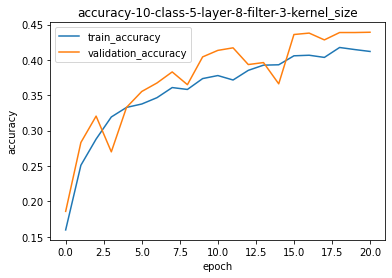

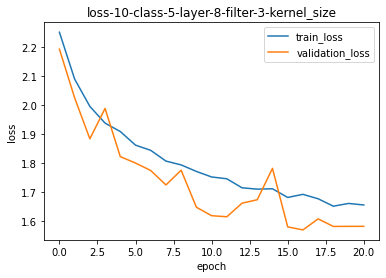

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-8-filter-3-kernel_size')
plt.savefig('accuracy-10-class-5-layer-8-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-8-filter-3-kernel_size')
plt.savefig('loss-10-class-5-layer-8-filter-3-kernel_size.jpg')

# **5 pairs 16 filter kernel_size 3**

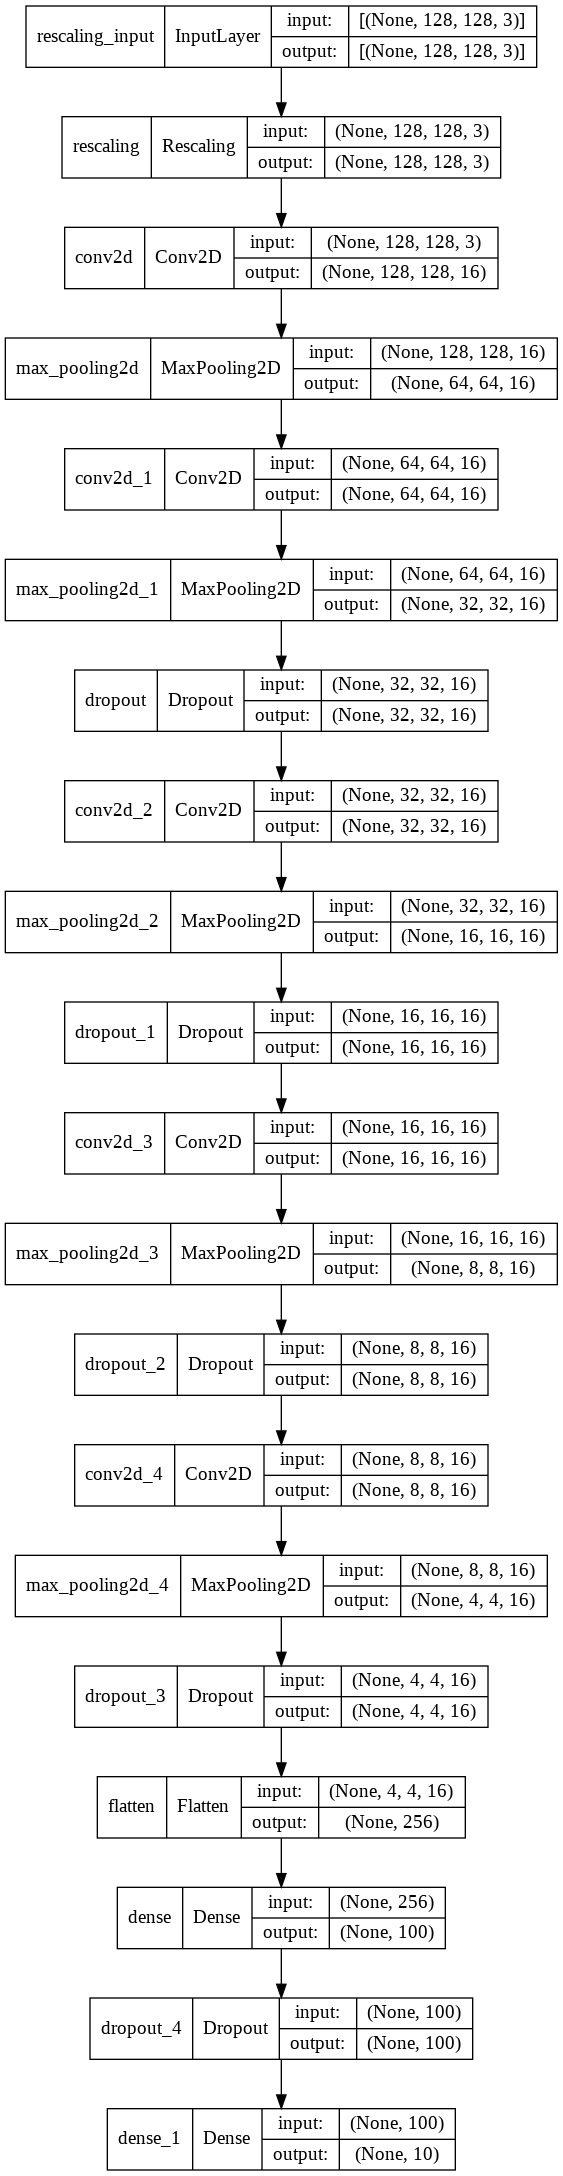

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 16
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 169s 358ms/step - loss: 2.2966 - accuracy: 0.1189 - val_loss: 2.3032 - val_accuracy: 0.0998
Epoch 2/30
468/468 [==============================] - 169s 360ms/step - loss: 2.2022 - accuracy: 0.1774 - val_loss: 2.0627 - val_accuracy: 0.2552
Epoch 3/30
468/468 [==============================] - 169s 360ms/step - loss: 2.0673 - accuracy: 0.2535 - val_loss: 1.9666 - val_accuracy: 0.3165
Epoch 4/30
468/468 [==============================] - 170s 363ms/step - loss: 1.9854 - accuracy: 0.2875 - val_loss: 1.8707 - val_accuracy: 0.3446
Epoch 5/30
468/468 [==============================] - 169s 360ms/step - loss: 1.9321 - accuracy: 0.3167 - val_loss: 1.7828 - val_accuracy: 0.3882
Epoch 6/30
468/468 [==============================] - 168s 359ms/step - loss: 1.8720 - accuracy: 0.3390 - val_loss: 1.7996 - val_accuracy: 0.3654
Epoch 7/30
468/468 [==================

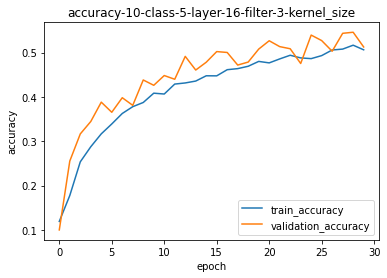

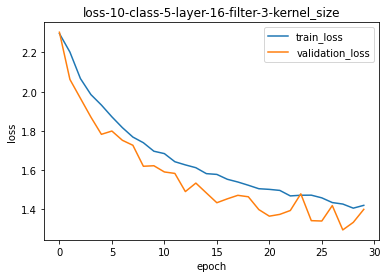

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-16-filter-3-kernel_size')
plt.savefig('accuracy-10-class-5-layer-16-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-16-filter-3-kernel_size')
plt.savefig('loss-10-class-5-layer-16-filter-3-kernel_size.jpg')

# **5 pairs 32 filter kernel_size 3**

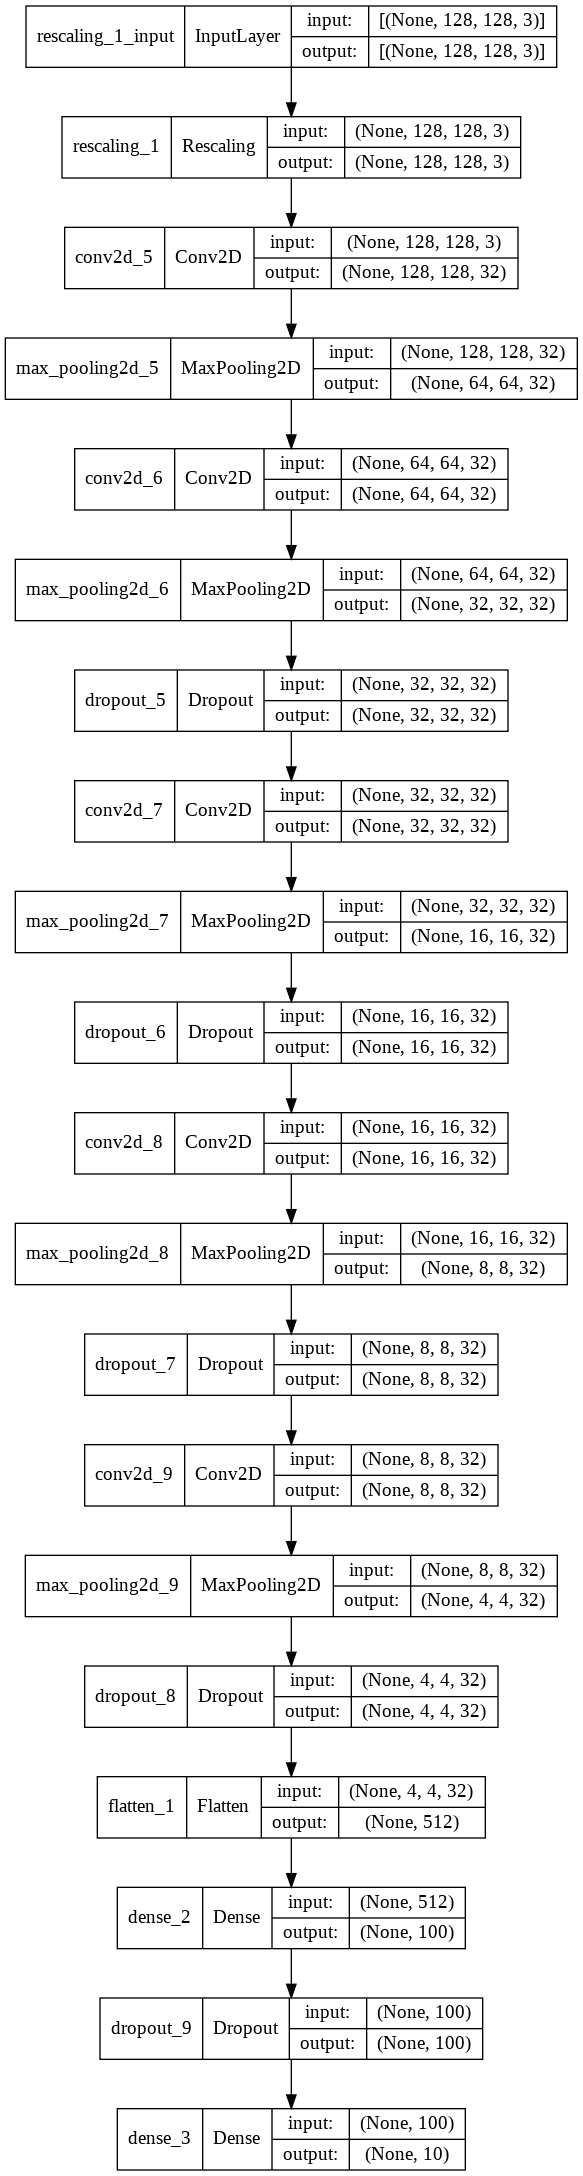

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 32
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 78s 164ms/step - loss: 2.2857 - accuracy: 0.1235 - val_loss: 2.2497 - val_accuracy: 0.1779
Epoch 2/50
468/468 [==============================] - 76s 162ms/step - loss: 2.1858 - accuracy: 0.1920 - val_loss: 2.1265 - val_accuracy: 0.2304
Epoch 3/50
468/468 [==============================] - 76s 162ms/step - loss: 2.1054 - accuracy: 0.2237 - val_loss: 2.0575 - val_accuracy: 0.2612
Epoch 4/50
468/468 [==============================] - 77s 164ms/step - loss: 2.0484 - accuracy: 0.2571 - val_loss: 1.9468 - val_accuracy: 0.3025
Epoch 5/50
468/468 [==============================] - 76s 163ms/step - loss: 1.9998 - accuracy: 0.2827 - val_loss: 1.8933 - val_accuracy: 0.3397
Epoch 6/50
468/468 [==============================] - 77s 165ms/step - loss: 1.9355 - accuracy: 0.3096 - val_loss: 1.8342 - val_accuracy: 0.3442
Epoch 7/50
468/468 [========================

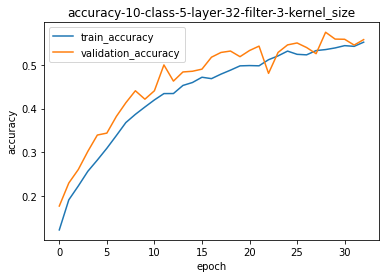

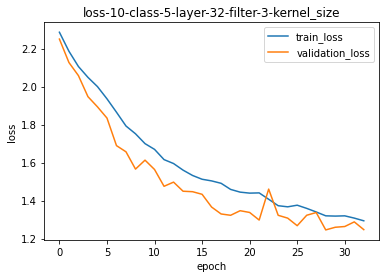

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-32-filter-3-kernel_size')
plt.savefig('accuracy-10-class-5-layer-32-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-32-filter-3-kernel_size')
plt.savefig('loss-10-class-5-layer-32-filter-3-kernel_size.jpg')

# **5 pairs 64 filter kernel_size 3**

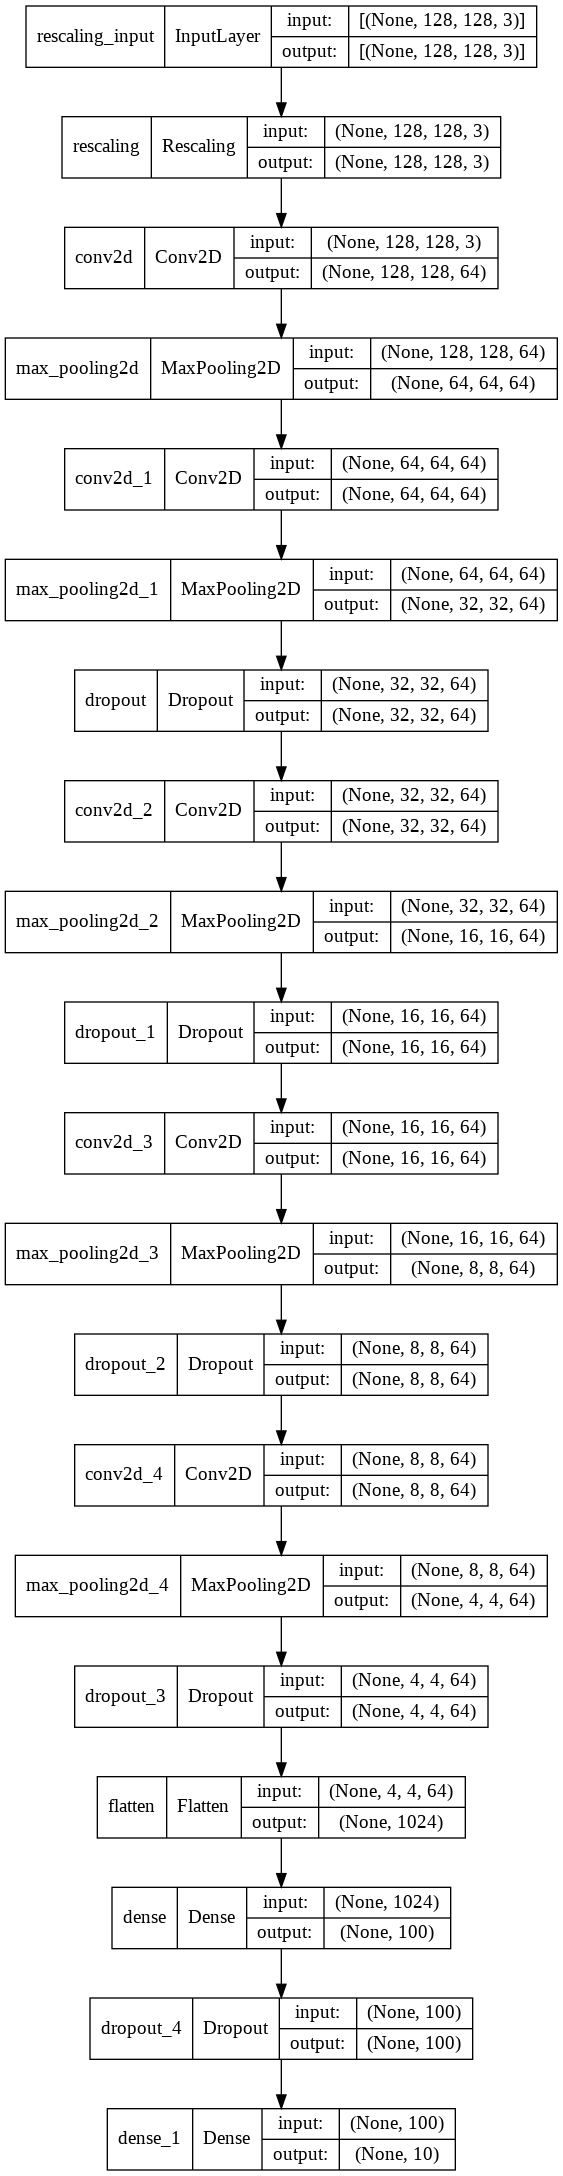

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 451s 961ms/step - loss: 2.3004 - accuracy: 0.1148 - val_loss: 2.2731 - val_accuracy: 0.1398
Epoch 2/30
468/468 [==============================] - 445s 950ms/step - loss: 2.2440 - accuracy: 0.1550 - val_loss: 2.1256 - val_accuracy: 0.2236
Epoch 3/30
468/468 [==============================] - 446s 952ms/step - loss: 2.1192 - accuracy: 0.2259 - val_loss: 1.9462 - val_accuracy: 0.3021
Epoch 4/30
468/468 [==============================] - 443s 946ms/step - loss: 1.9698 - accuracy: 0.2982 - val_loss: 1.8397 - val_accuracy: 0.3614
Epoch 5/30
468/468 [==============================] - 447s 955ms/step - loss: 1.8890 - accuracy: 0.3279 - val_loss: 1.6959 - val_accuracy: 0.4006
Epoch 6/30
468/468 [==============================] - 440s 940ms/step - loss: 1.8119 - accuracy: 0.3605 - val_loss: 1.6713 - val_accuracy: 0.4355
Epoch 7/30
468/468 [==================

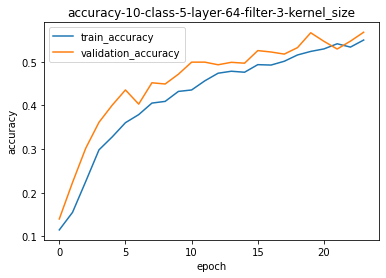

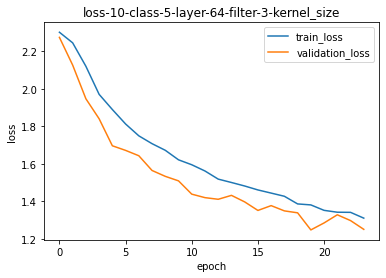

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-3-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-3-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-3-kernel_size.jpg')

# **5 pairs 128 filter kernel_size 3**

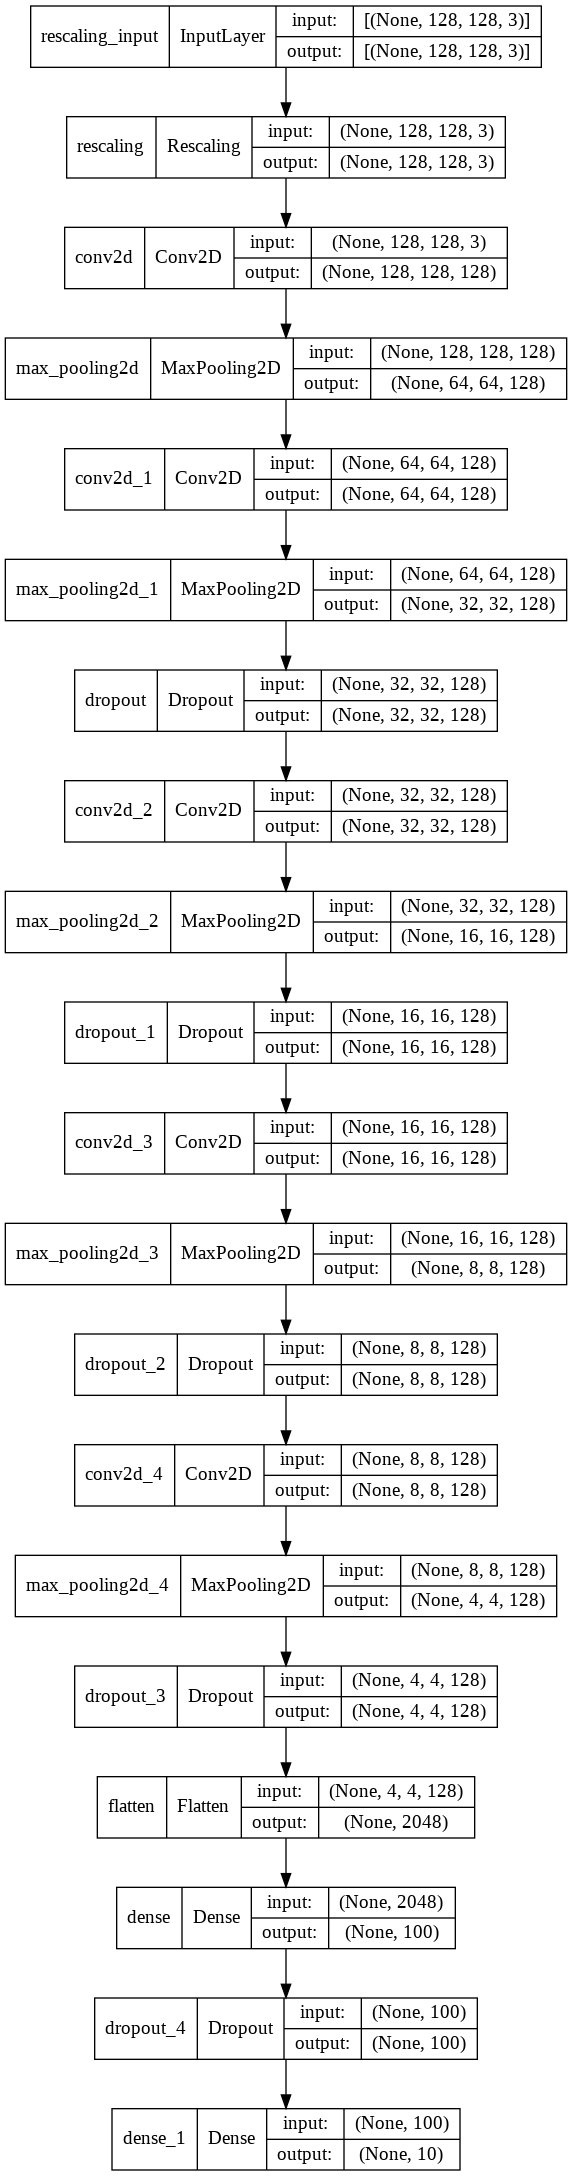

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 128
kernel_size = 3
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 102s 186ms/step - loss: 2.3047 - accuracy: 0.0985 - val_loss: 2.3027 - val_accuracy: 0.0998
Epoch 2/50
468/468 [==============================] - 86s 184ms/step - loss: 2.3035 - accuracy: 0.0917 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 3/50
468/468 [==============================] - 86s 184ms/step - loss: 2.3030 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.0994
Epoch 4/50
468/468 [==============================] - 82s 174ms/step - loss: 2.3032 - accuracy: 0.0938 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/50
468/468 [==============================] - 81s 174ms/step - loss: 2.3030 - accuracy: 0.0925 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 6/50
468/468 [==============================] - 84s 179ms/step - loss: 2.3030 - accuracy: 0.0970 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/50
468/468 [=======================

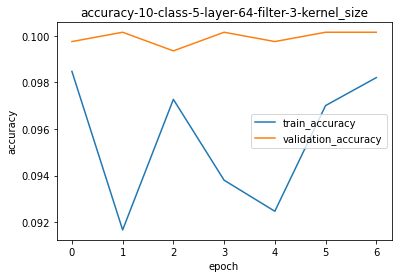

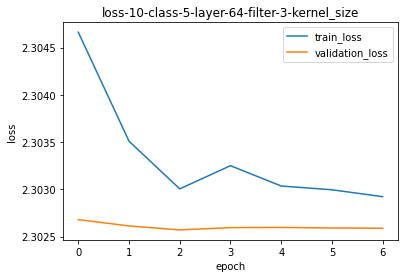

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-3-kernel_size')
plt.savefig('accuracy-10-class-5-layer-128-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-3-kernel_size')
plt.savefig('loss-10-class-5-layer-128-filter-3-kernel_size.jpg')

# **5 pairs 128 filter kernel_size 3 with 512 Neuron in  dense layer**

In [ ]:
def generate_model_v3(n_pairs,n_filters,kernel_size):
  model = tf.keras.Sequential(
  [
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(n_filters, (kernel_size,kernel_size), padding='same', activation="relu",input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  ]
  )
  for i in range(n_pairs-1):
    model.add(tf.keras.layers.Conv2D(n_filters, (kernel_size,kernel_size), padding='same', activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation="relu"))
  model.add(tf.keras.layers.Dense(100, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(10, activation="softmax"))
  input_shape = (None, 128, 128, 3)
  model.build(input_shape)
  
  return model


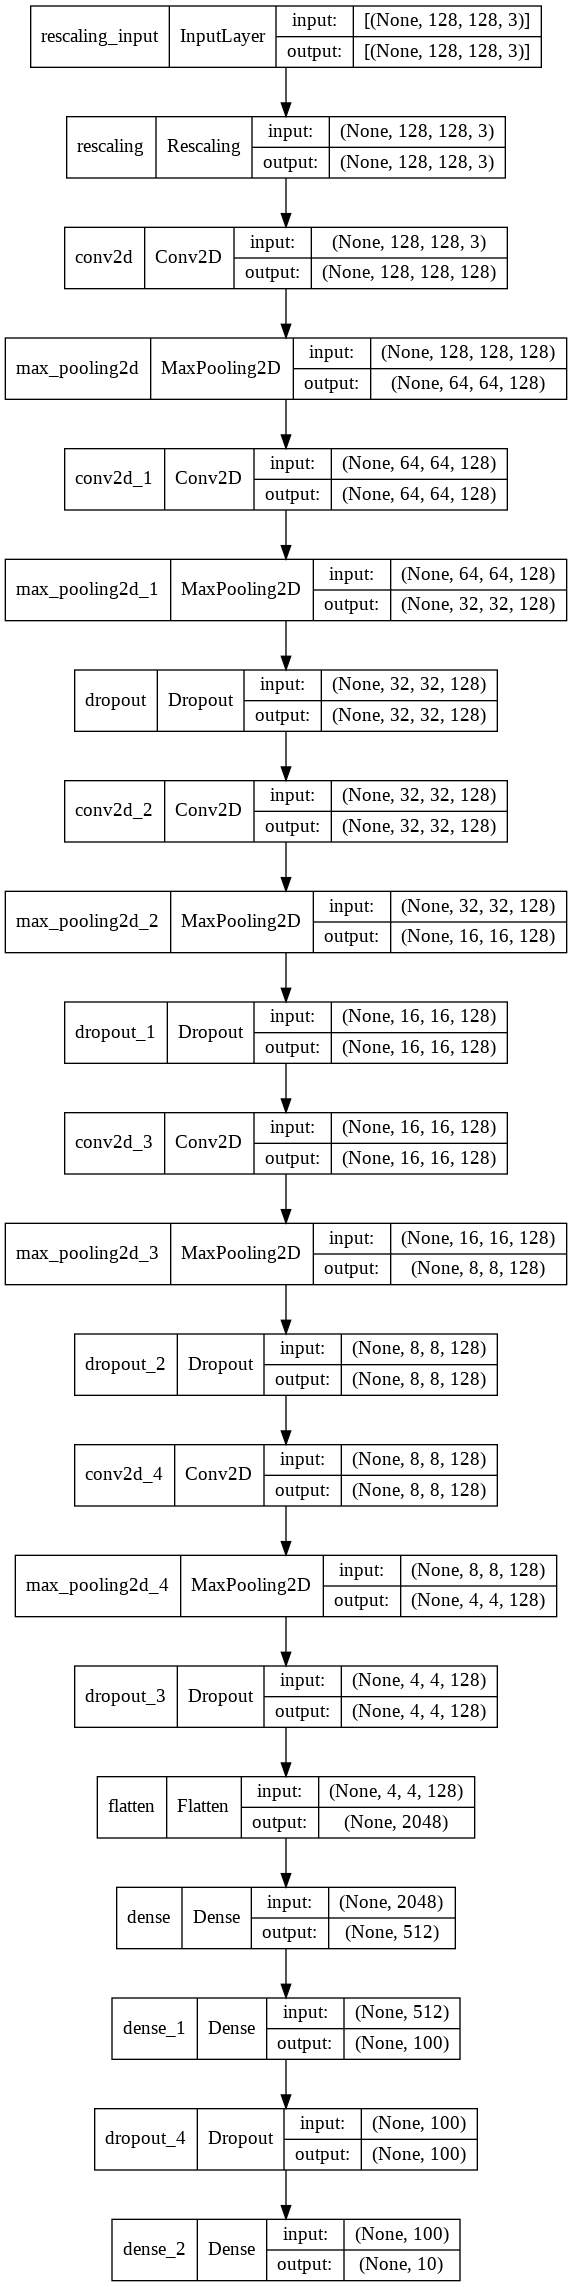

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 128
kernel_size = 3
model = generate_model_v3(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/50
468/468 [==============================] - 87s 184ms/step - loss: 2.3037 - accuracy: 0.0914 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 2/50
468/468 [==============================] - 86s 184ms/step - loss: 2.3030 - accuracy: 0.0879 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 3/50
468/468 [==============================] - 85s 182ms/step - loss: 2.3029 - accuracy: 0.0934 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 4/50
468/468 [==============================] - 83s 178ms/step - loss: 2.3029 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/50
468/468 [==============================] - 83s 178ms/step - loss: 2.3029 - accuracy: 0.0961 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 6/50
468/468 [==============================] - 83s 178ms/step - loss: 2.3029 - accuracy: 0.0923 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 7/50
468/468 [========================

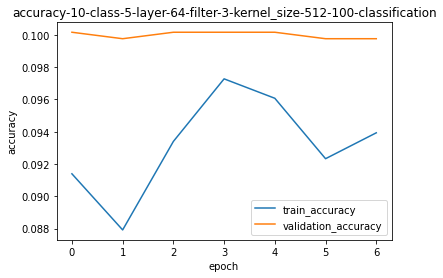

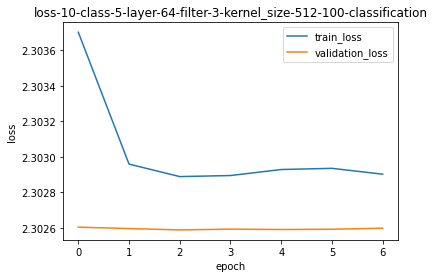

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-3-kernel_size-512-100-classification')
plt.savefig('accuracy-10-class-5-layer-128-filter-3-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-3-kernel_size-512-100-classification')
plt.savefig('loss-10-class-5-layer-128-filter-3-kernel_size.jpg')

# **As you can seen, the best architecture consists of 64 kernel**

# **Kernel Size**

## **5 pairs 64 filter kernel_size 5**

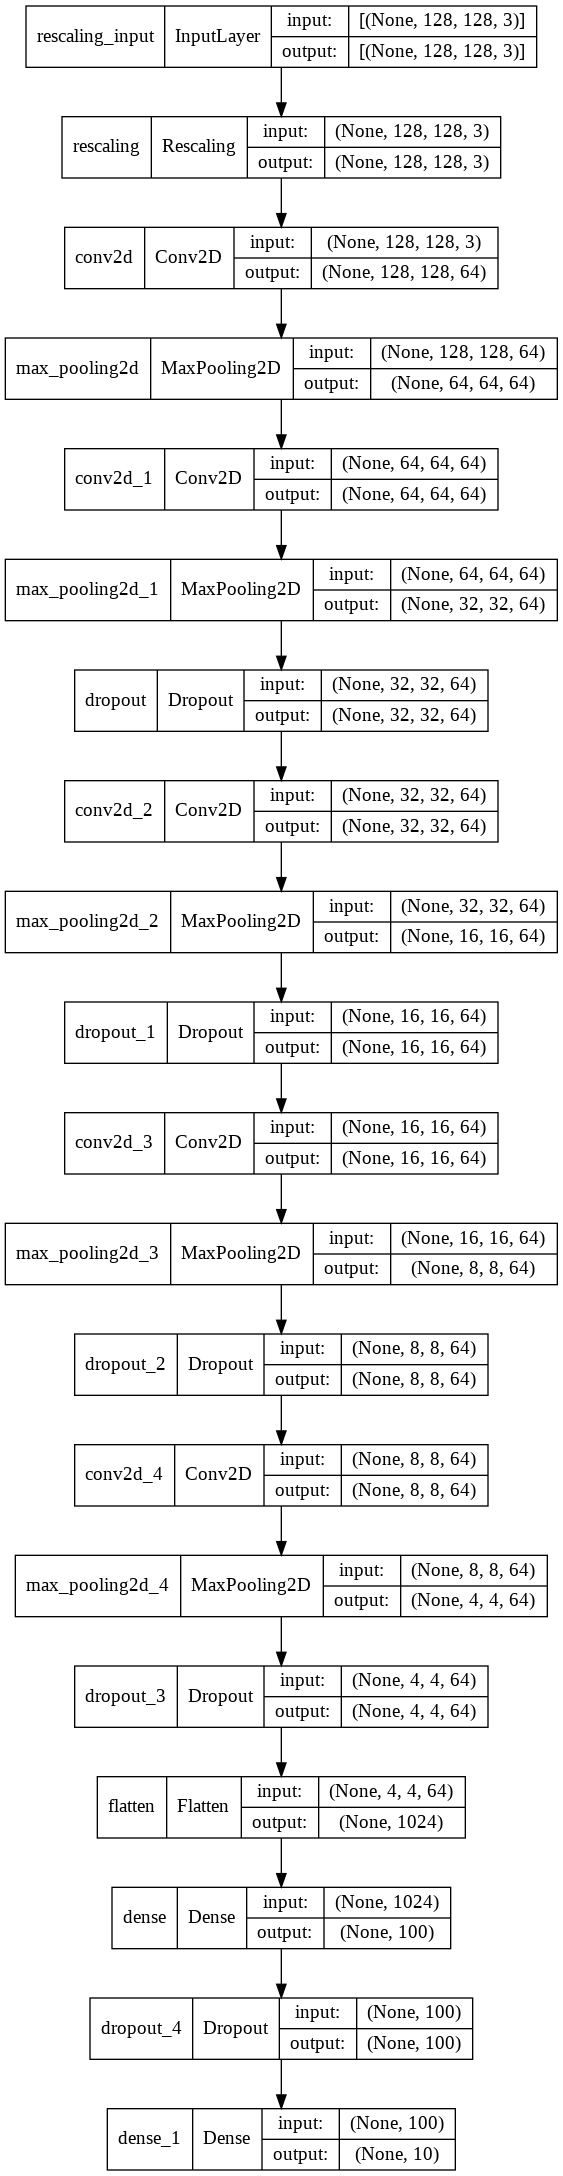

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 5
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 86s 179ms/step - loss: 2.3036 - accuracy: 0.0963 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 2/30
468/468 [==============================] - 84s 180ms/step - loss: 2.3030 - accuracy: 0.0970 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 3/30
468/468 [==============================] - 84s 180ms/step - loss: 2.3029 - accuracy: 0.0930 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 4/30
468/468 [==============================] - 81s 173ms/step - loss: 2.3029 - accuracy: 0.0982 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/30
468/468 [==============================] - 81s 173ms/step - loss: 2.3029 - accuracy: 0.0949 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 6/30
468/468 [==============================] - 81s 174ms/step - loss: 2.3029 - accuracy: 0.0895 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 7/30
468/468 [========================

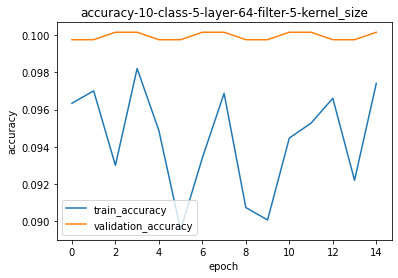

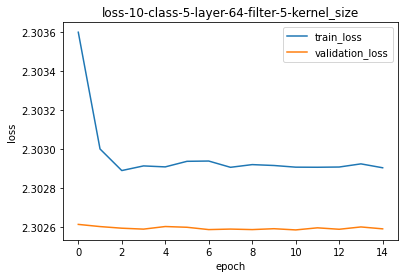

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-5-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-5-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-5-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-5-kernel_size.jpg')

# **5 pairs 64 filter kernel_size 7**

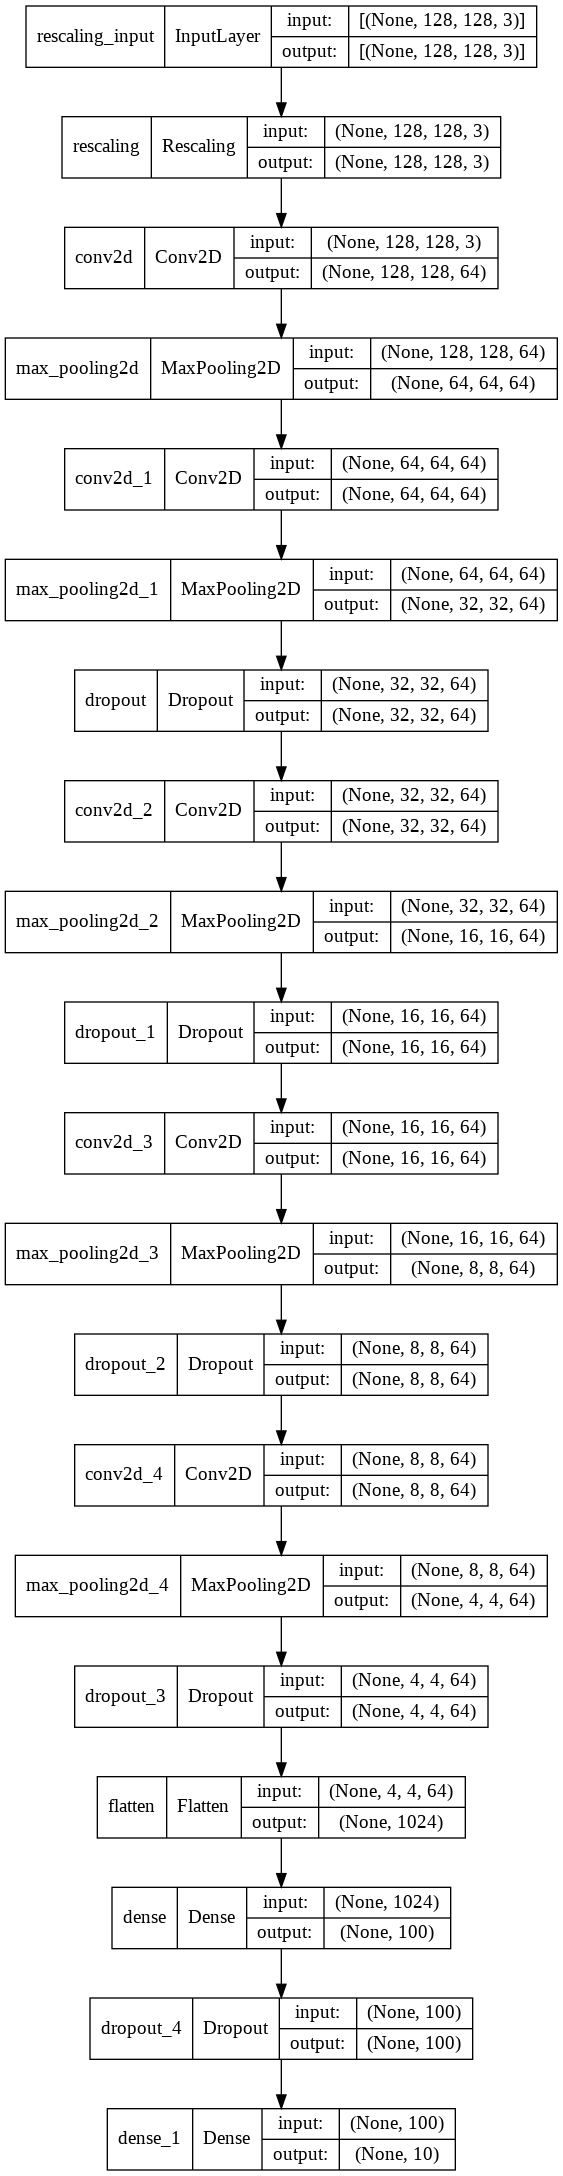

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 7
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 93s 194ms/step - loss: 2.3042 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 2/30
468/468 [==============================] - 90s 192ms/step - loss: 2.3031 - accuracy: 0.0941 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 3/30
468/468 [==============================] - 91s 195ms/step - loss: 2.3030 - accuracy: 0.0959 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 4/30
468/468 [==============================] - 92s 196ms/step - loss: 2.3029 - accuracy: 0.0945 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/30
468/468 [==============================] - 88s 188ms/step - loss: 2.3030 - accuracy: 0.0953 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 6/30
468/468 [==============================] - 98s 209ms/step - loss: 2.3029 - accuracy: 0.0955 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/30
468/468 [========================

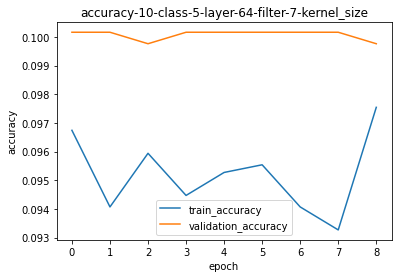

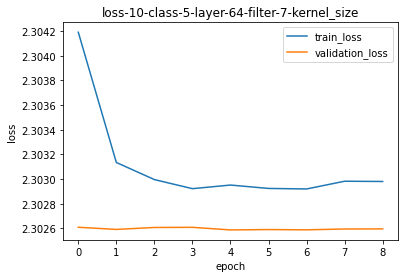

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-7-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-7-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-7-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-7-kernel_size.jpg')

# **5 pairs 64 filter kernel_size 9**

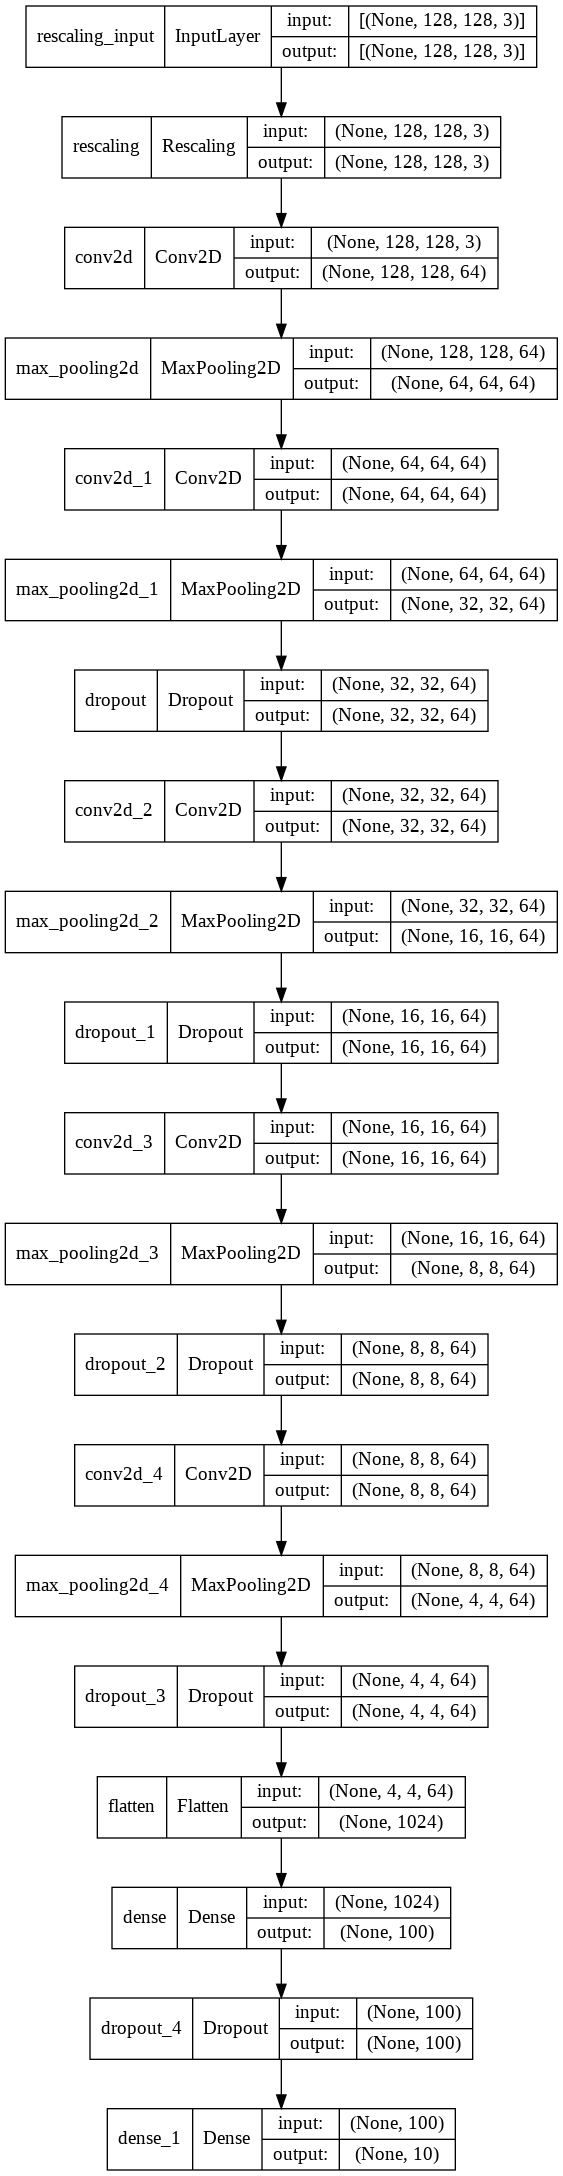

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 9
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 95s 198ms/step - loss: 2.3039 - accuracy: 0.0954 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 2/30
468/468 [==============================] - 93s 198ms/step - loss: 2.3029 - accuracy: 0.0955 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 3/30
468/468 [==============================] - 90s 193ms/step - loss: 2.3030 - accuracy: 0.0931 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 4/30
468/468 [==============================] - 90s 191ms/step - loss: 2.3030 - accuracy: 0.0893 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/30
468/468 [==============================] - 90s 193ms/step - loss: 2.3029 - accuracy: 0.0945 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 6/30
468/468 [==============================] - 92s 196ms/step - loss: 2.3029 - accuracy: 0.0937 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/30
468/468 [========================

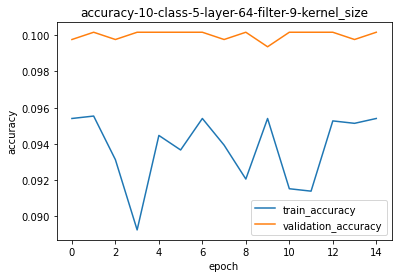

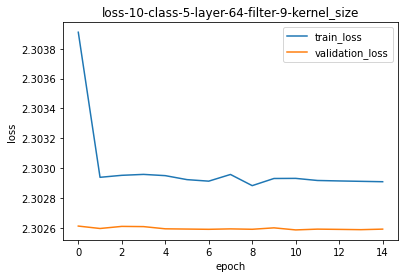

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-9-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-9-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-9-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-9-kernel_size.jpg')

# **5 pairs 64 filter kernel_size 11**

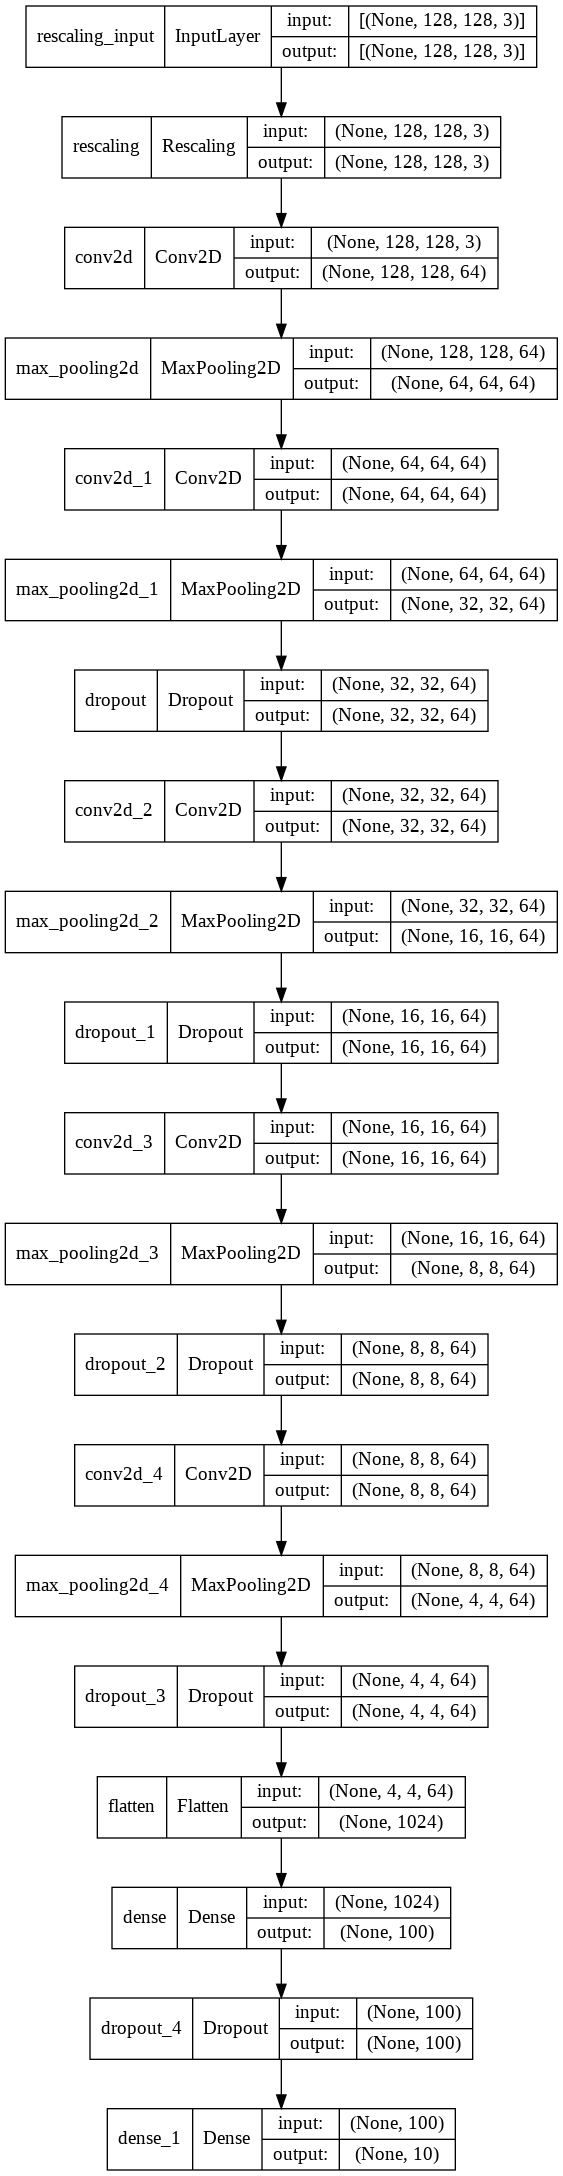

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 11
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 96s 199ms/step - loss: 2.3140 - accuracy: 0.0914 - val_loss: 2.3026 - val_accuracy: 0.0994
Epoch 2/30
468/468 [==============================] - 92s 196ms/step - loss: 2.3030 - accuracy: 0.0947 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 3/30
468/468 [==============================] - 91s 194ms/step - loss: 2.3029 - accuracy: 0.0935 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 4/30
468/468 [==============================] - 91s 194ms/step - loss: 2.3030 - accuracy: 0.0951 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/30
468/468 [==============================] - 93s 199ms/step - loss: 2.3029 - accuracy: 0.0911 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 6/30
468/468 [==============================] - 90s 192ms/step - loss: 2.3029 - accuracy: 0.0943 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/30
468/468 [========================

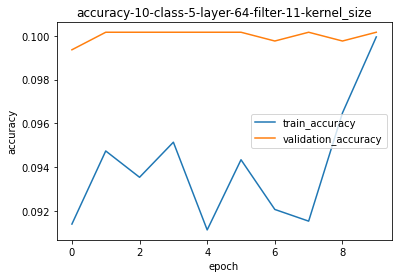

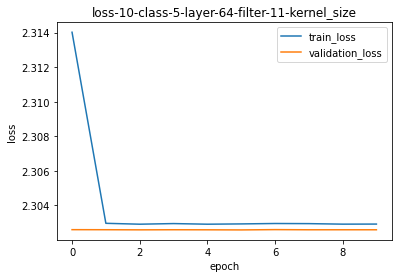

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-11-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-11-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-11-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-11-kernel_size.jpg')

# **5 pairs 64 filter kernel_size 13**

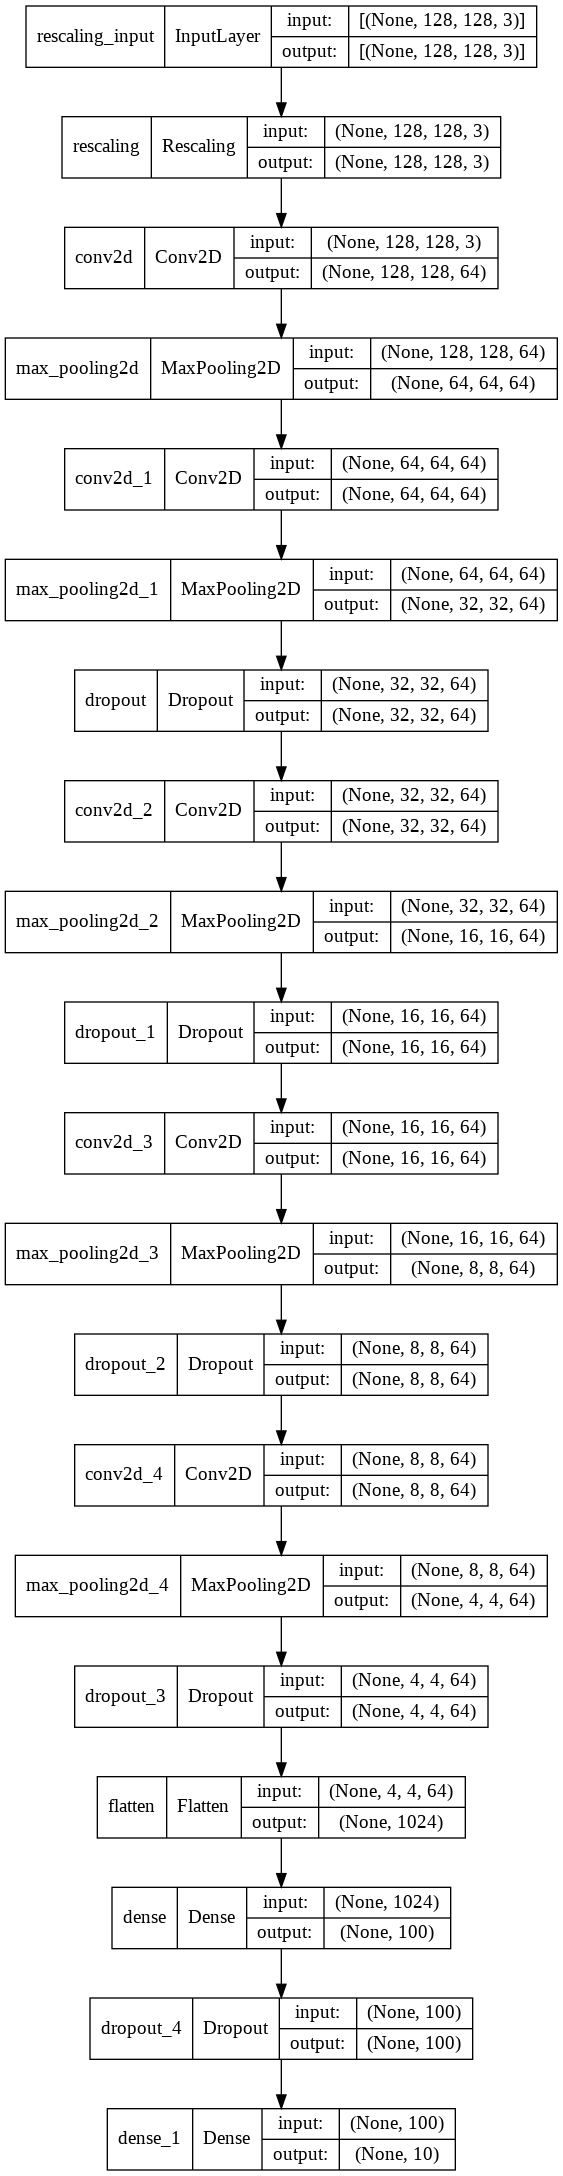

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 13
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 98s 201ms/step - loss: 2.3585 - accuracy: 0.0947 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 2/30
468/468 [==============================] - 93s 198ms/step - loss: 2.3030 - accuracy: 0.0951 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 3/30
468/468 [==============================] - 99s 211ms/step - loss: 2.3030 - accuracy: 0.0930 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 4/30
468/468 [==============================] - 92s 197ms/step - loss: 2.3030 - accuracy: 0.0886 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/30
468/468 [==============================] - 92s 197ms/step - loss: 2.3029 - accuracy: 0.0951 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 6/30
468/468 [==============================] - 90s 192ms/step - loss: 2.3030 - accuracy: 0.0945 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/30
468/468 [========================

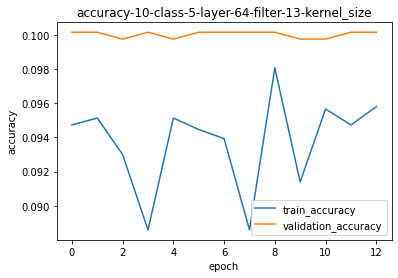

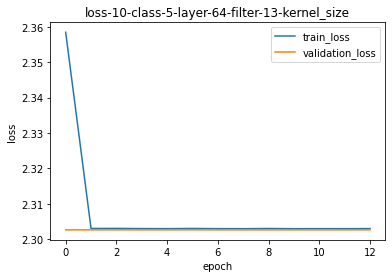

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-13-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-13-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-13-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-13-kernel_size.jpg')

# **5 pairs 64 filter kernel_size 15**

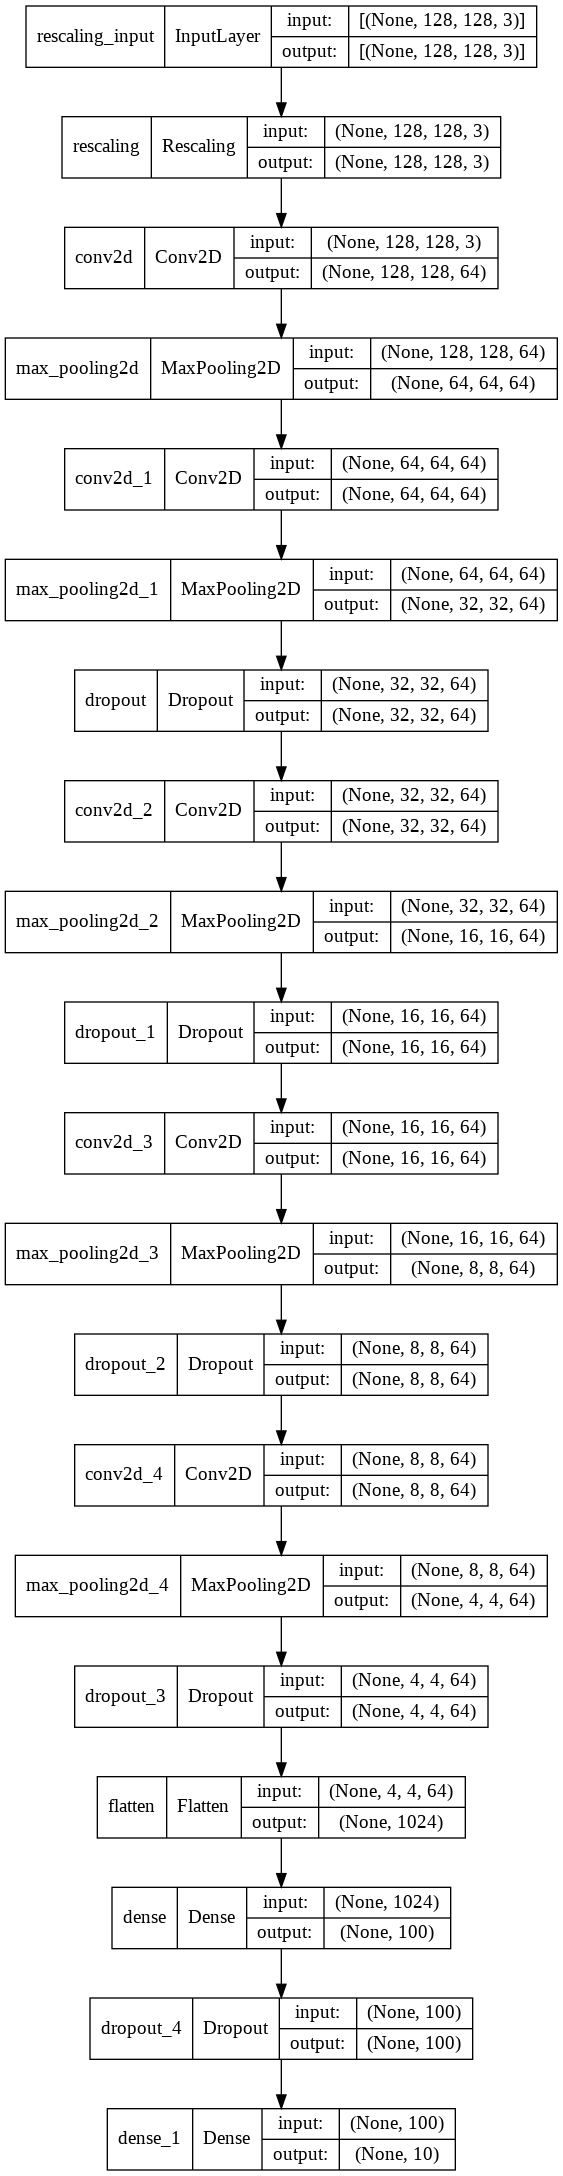

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 15
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [ ]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 99s 203ms/step - loss: 2.4855 - accuracy: 0.0985 - val_loss: 2.3026 - val_accuracy: 0.0994
Epoch 2/30
468/468 [==============================] - 93s 199ms/step - loss: 2.3031 - accuracy: 0.0958 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 3/30
468/468 [==============================] - 93s 199ms/step - loss: 2.3029 - accuracy: 0.0985 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 4/30
468/468 [==============================] - 90s 192ms/step - loss: 2.3030 - accuracy: 0.0939 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/30
468/468 [==============================] - 90s 192ms/step - loss: 2.3029 - accuracy: 0.0961 - val_loss: 2.3026 - val_accuracy: 0.0994
Epoch 6/30
468/468 [==============================] - 93s 198ms/step - loss: 2.3029 - accuracy: 0.0985 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 7/30
468/468 [========================

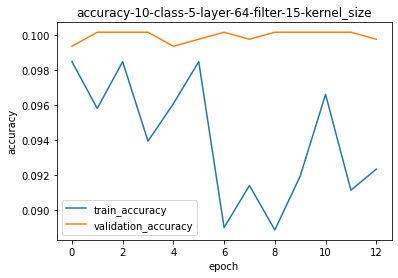

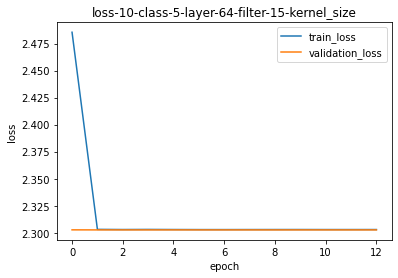

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-15-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-15-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-15-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-15-kernel_size.jpg')

# **5 pairs 64 filter kernel_size 17**

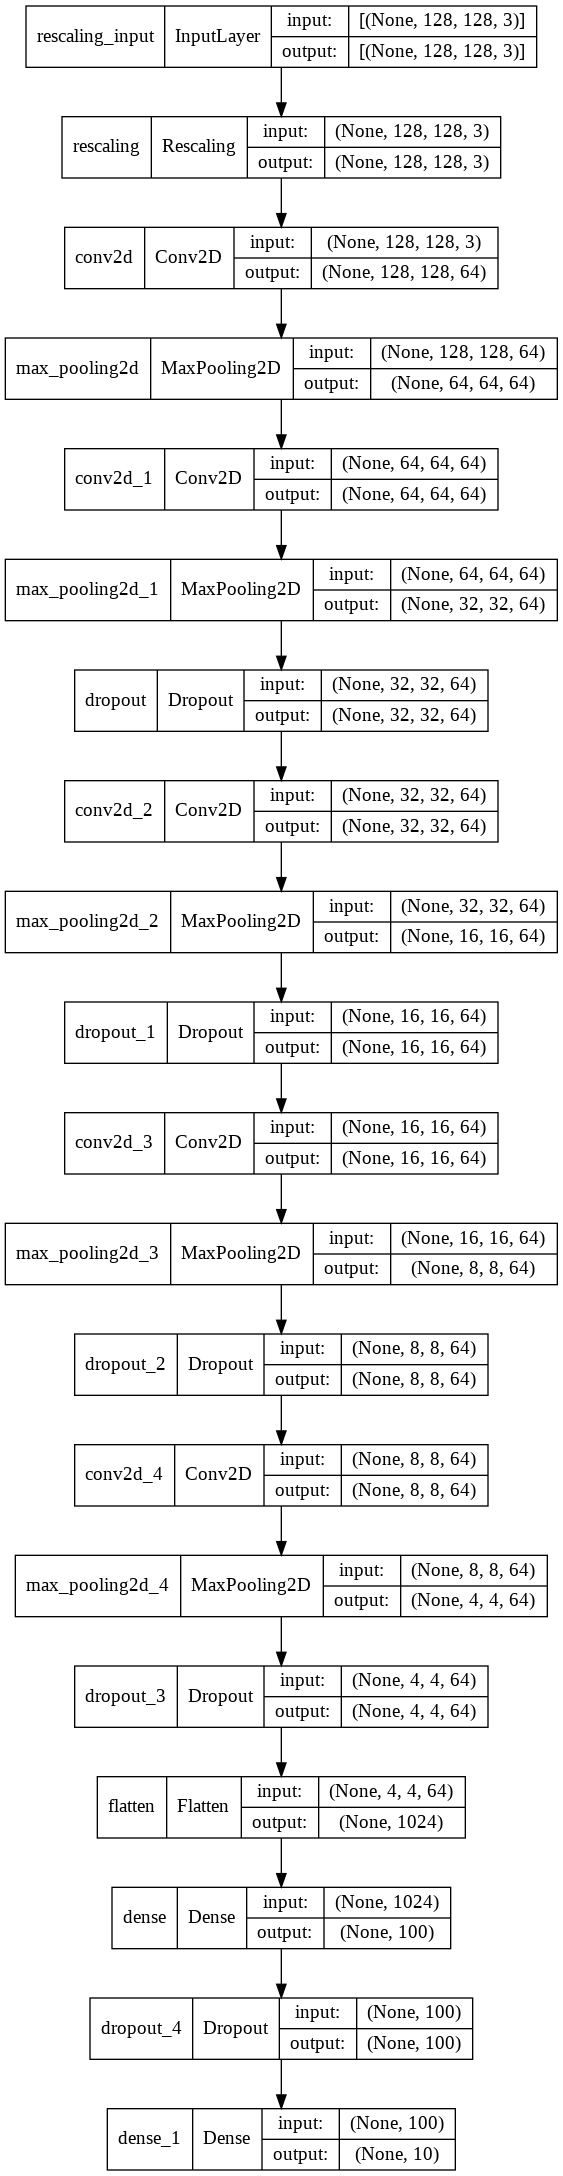

In [18]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 17
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [19]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 115s 210ms/step - loss: 2.3315 - accuracy: 0.0994 - val_loss: 2.3028 - val_accuracy: 0.1002
Epoch 2/30
468/468 [==============================] - 95s 204ms/step - loss: 2.3032 - accuracy: 0.0939 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 3/30
468/468 [==============================] - 95s 203ms/step - loss: 2.3029 - accuracy: 0.0915 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 4/30
468/468 [==============================] - 91s 194ms/step - loss: 2.3029 - accuracy: 0.0941 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/30
468/468 [==============================] - 92s 197ms/step - loss: 2.3030 - accuracy: 0.0931 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 6/30
468/468 [==============================] - 92s 195ms/step - loss: 2.3029 - accuracy: 0.0946 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/30
468/468 [=======================

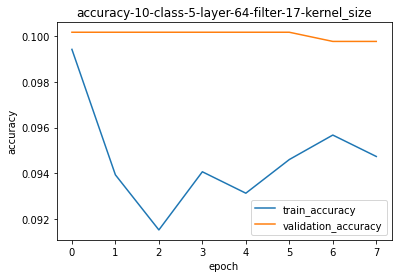

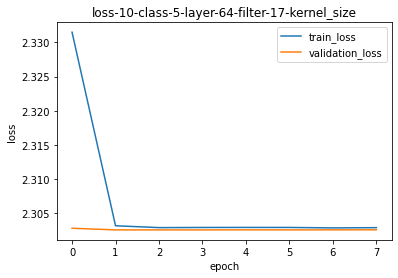

<Figure size 432x288 with 0 Axes>

In [20]:

plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-17-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-17-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-17-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-17-kernel_size.jpg')

  # **5 pairs 64 filter kernel_size 19**

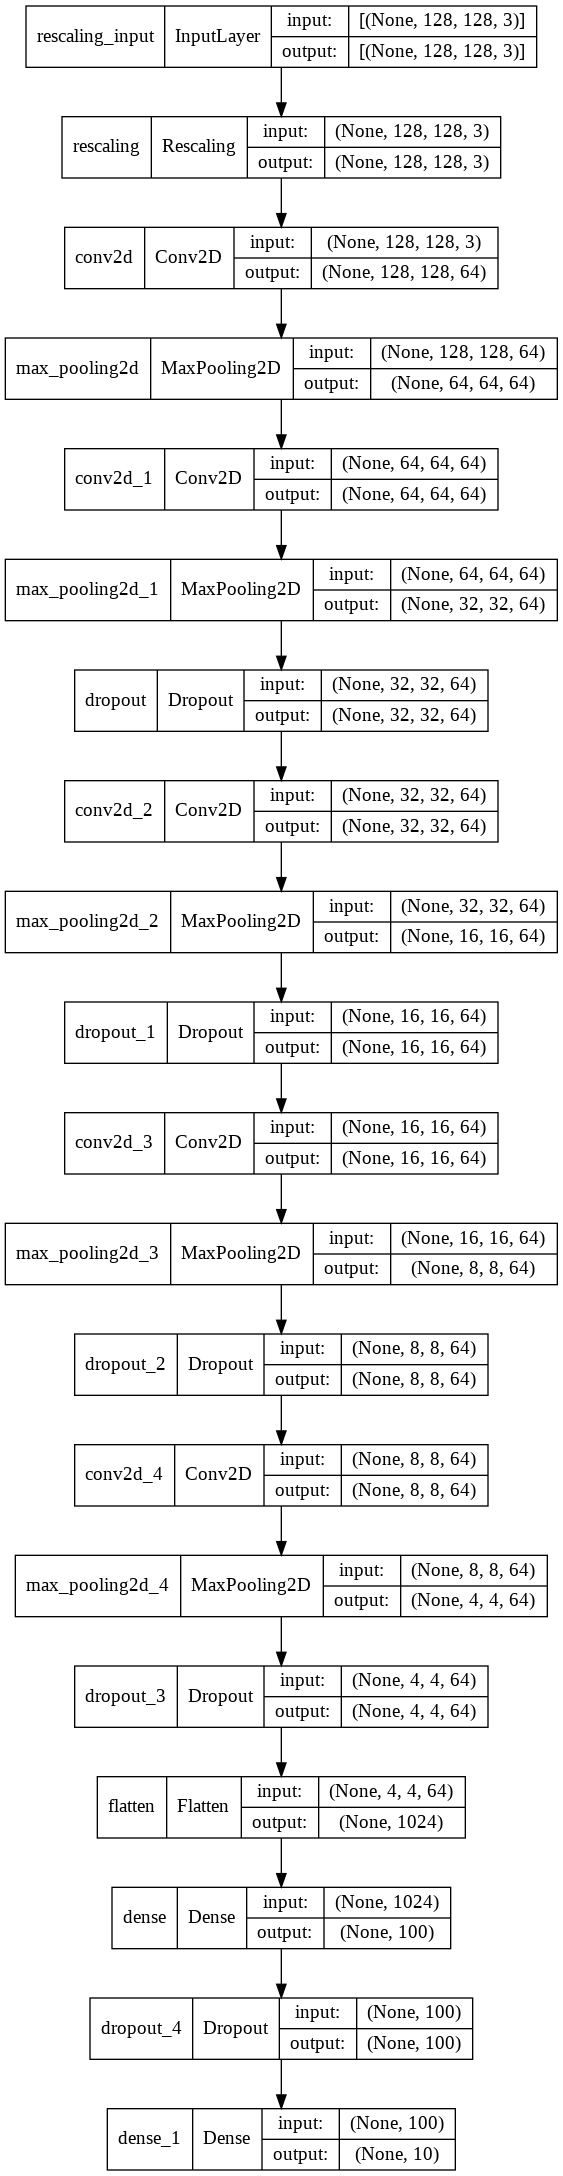

In [21]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 19
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [22]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 108s 216ms/step - loss: 2.4100 - accuracy: 0.0937 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 2/30
468/468 [==============================] - 99s 211ms/step - loss: 2.3029 - accuracy: 0.0931 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 3/30
468/468 [==============================] - 97s 207ms/step - loss: 2.3030 - accuracy: 0.0935 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 4/30
468/468 [==============================] - 97s 206ms/step - loss: 2.3029 - accuracy: 0.0950 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 5/30
468/468 [==============================] - 98s 210ms/step - loss: 2.3029 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 6/30
468/468 [==============================] - 95s 203ms/step - loss: 2.3029 - accuracy: 0.0918 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/30
468/468 [=======================

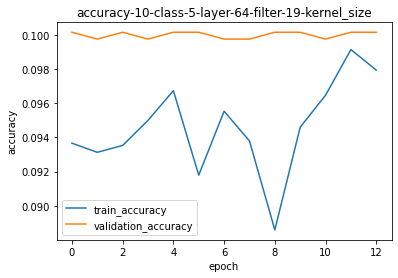

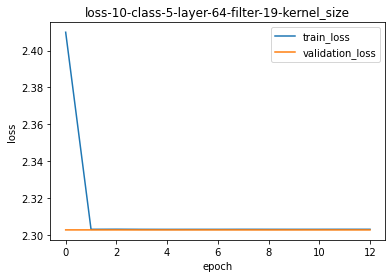

<Figure size 432x288 with 0 Axes>

In [23]:

plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-19-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-19-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-19-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-19-kernel_size.jpg')

# **5 pairs 64 filter kernel_size 21**

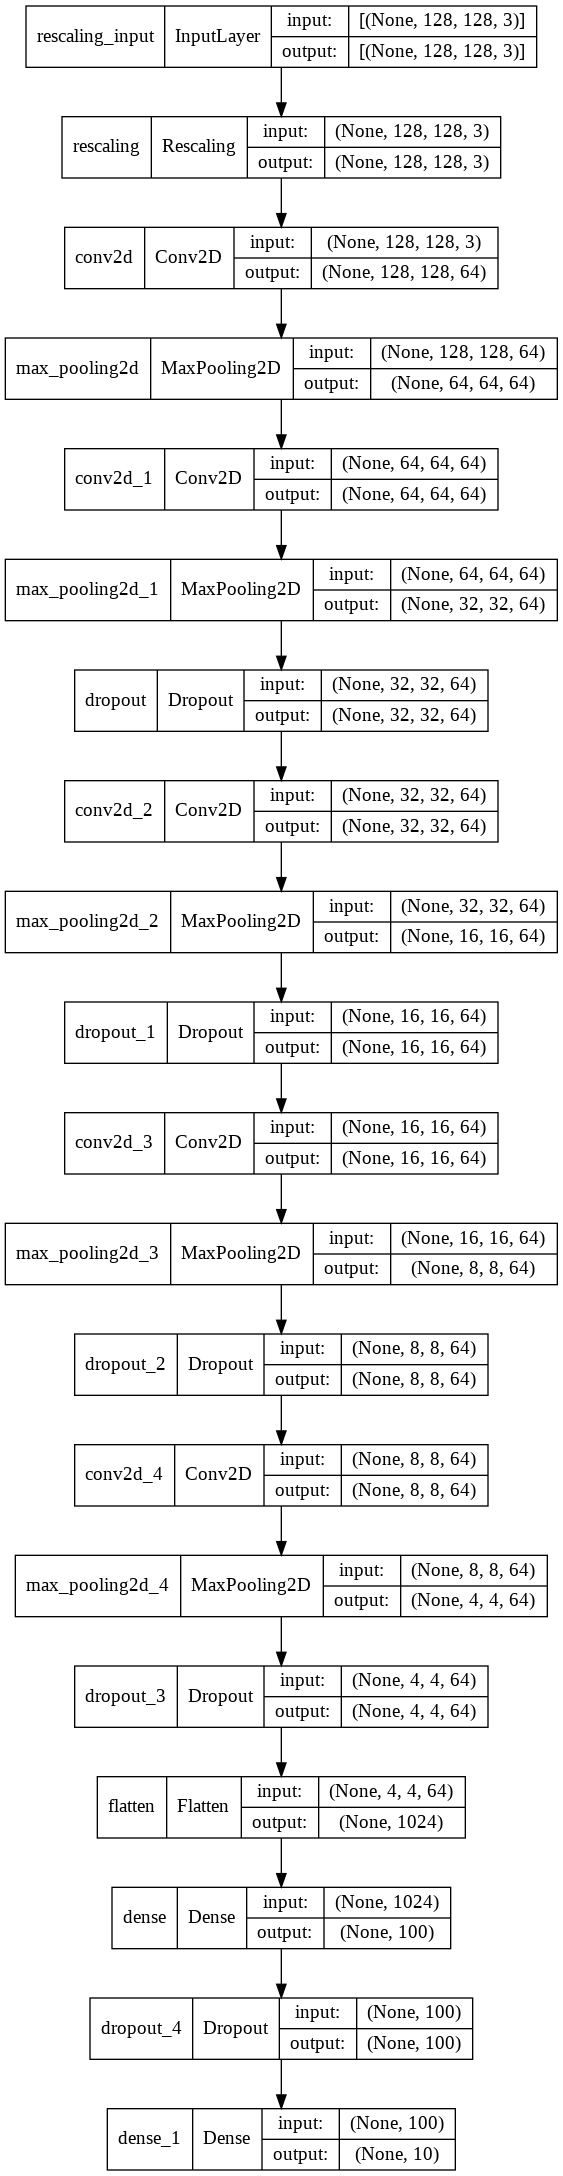

In [24]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 30
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 64
kernel_size = 21
model = generate_model(n_pairs,n_filters,kernel_size)
keras.utils.plot_model(model,show_shapes=True)#show_shapes=True,show_layer_names=True,expand_nested=True


In [25]:
history, class_map_10, model = train_model_v2(model,n_classes,epochs, nb_train_samples,nb_validation_samples)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/30
468/468 [==============================] - 111s 221ms/step - loss: 2.3482 - accuracy: 0.0975 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 2/30
468/468 [==============================] - 97s 207ms/step - loss: 2.3030 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 3/30
468/468 [==============================] - 98s 209ms/step - loss: 2.3029 - accuracy: 0.0945 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 4/30
468/468 [==============================] - 99s 211ms/step - loss: 2.3029 - accuracy: 0.0966 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/30
468/468 [==============================] - 94s 200ms/step - loss: 2.3030 - accuracy: 0.0950 - val_loss: 2.3026 - val_accuracy: 0.0998
Epoch 6/30
468/468 [==============================] - 97s 208ms/step - loss: 2.3029 - accuracy: 0.0951 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 7/30
468/468 [=======================

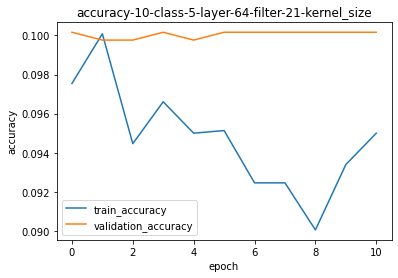

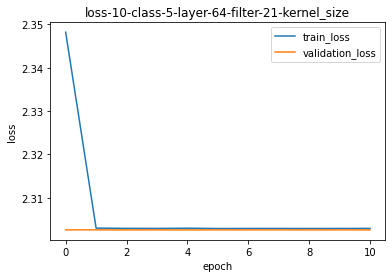

<Figure size 432x288 with 0 Axes>

In [26]:
plot_accuracy(history,'accuracy-10-class-5-layer-64-filter-21-kernel_size')
plt.savefig('accuracy-10-class-5-layer-64-filter-21-kernel_size.jpg')

plot_loss(history,'loss-10-class-5-layer-64-filter-21-kernel_size')
plt.savefig('loss-10-class-5-layer-64-filter-21-kernel_size.jpg')